In [1]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [2]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [3]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [4]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [5]:
m_true = 0.0
b_true = .5

delty1_true = 0.0
delty2_true = 0.3
sigsq1_true = .01
sigsq2_true = .04
a1_true = .5
a2_true = .5
L_true = 1.0

In [6]:
# adapted code from http://code.activestate.com/recipes/189971-basic-linear-algebra-matrix/
def minor(matrix, i, j):
    #input should be numpy matrix
    matrix = np.asarray(matrix)
    m = np.zeros((matrix.shape[0]-1, matrix.shape[1]-1))
    m = np.matrix(m)
    # loop through the matrix, skipping over the row and column specified by i and j
    minor_row = minor_col = 0
    for row in range(matrix.shape[0]):
        if not row == i: # skip row i
            for col in range(matrix.shape[1]):
                if not col == j: # skip column j
                    m[(minor_row, minor_col)] = matrix[(row, col)]
                    minor_col += 1
            minor_col = 0
            minor_row += 1
    return m

In [72]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
#     a2 = 1.0 - a1
    BN_lim = 200
    #number in variable name is the gaussian j
    
#     delty1_true = 0.0
#     delty2_true = 0.3
#     sigsq1_true = .01
#     sigsq2_true = .04

    y_mod1 = m*x + b - delty1
    y_mod2 = m*x + b - delty2
    chisq1 = (1/sigsq1) * np.matmul(y-y_mod1, (y-y_mod1).T)
#     print(chisq1)
#     print(delty1/sigsq1)
    chisq2 = (1/sigsq2) * np.matmul(y-y_mod2, (y-y_mod2).T)
    if chisq1 > BN_lim:
        chisq1 = BN_lim
    if chisq2 > BN_lim:
        chisq2 = BN_lim
    H = [np.exp(-chisq1/2), np.exp(-chisq2/2)]
#     print(H)
    beta1 = -2.0*np.log(a1/np.sqrt(2*np.pi*sigsq1))
    beta2 = -2.0*np.log(a2/np.sqrt(2*np.pi*sigsq2))
    M = []
    for i in range(len(days)):
        if i == 0:
            temp_y = y[i+1:]
            temp_x = x[i+1:]
        else:
            temp_y = np.concatenate((y[:i],y[i+1:]))
            temp_x = np.concatenate((x[:i],x[i+1:]))
        temp_y_mod1 = m*temp_x + b - delty1
        temp_y_mod2 = m*temp_x + b - delty2
        minor_chisq1 = sigsq1 * np.matmul(temp_y-temp_y_mod1, (temp_y-temp_y_mod1).T)
        minor_chisq2 = sigsq2 * np.matmul(temp_y-temp_y_mod2, (temp_y-temp_y_mod2).T)
        M.append([np.exp(-.5*(beta1 - minor_chisq1)), np.exp(-.5*(beta2 - minor_chisq2))])
    
    MxH = np.matmul(np.matrix(M), np.matrix(H).T)
    
    #calc optimal lambda
    full_a = np.array([[a1, a2],]*len(x))
    full_H = np.array([H,]*len(x))
    N = np.multiply(np.divide(M,full_a),full_H)
    NxH = np.matmul(np.matrix(N), np.matrix(H).T)
    lambda_star = -0.5*np.sum(np.divide(NxH,MxH))
    print(lambda_star)
#     if np.any(MxH)<= 0:
#         print(MxH)
#         exit()
    return np.log(MxH).sum() + L*(a1+a2-1)

In [34]:
print(np.exp(-200))
print(np.finfo(np.float64).eps)

1.38389652674e-87
2.22044604925e-16


In [22]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, delty1_true, delty2_true, sigsq1_true, sigsq2_true, a1_true, a2_true, L_true], args=(days, planets_etamb))
m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml, a2_ml, L_ml = result["x"]

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [23]:
print(m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml)

0.0 0.5 0.0 0.3 0.01 0.04 0.5


In [73]:
def lnprior(theta):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
    if 0.0 < b < 1.0 and 0.0 < a1 < 1.0 and 0.0 < a2 < 1.0 and sigsq1 > 0.0 and sigsq2 > 0.0 and L > 0.0:
        pri_m = norm.logpdf(m, 0.0, 1.0)
        pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
        pri_delty2 = norm.logpdf(delty2, 0.3, 0.5)
        pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
        pri_sigsq2 = norm.logpdf(sigsq2, .04, .01)
        pri_a1 = norm.logpdf(a1, 0.5, .5/3.0)
        pri_a2 = norm.logpdf(a2, 0.5, .5/3.0)
        return pri_m + pri_delty1 + pri_delty2 + pri_sigsq1 + pri_sigsq2 + pri_a1 + pri_a2
#         return pri_m + pri_a1
    return -np.inf

In [74]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [75]:
ndim, nwalkers = 9, 200
# pos = [result["x"] + np.random.randn(ndim)*1e-4*[.2, .1, .5, .3, .3] for i in range(nwalkers)] #nwalkers x ndim entries
pos = [np.random.randn(ndim)*1e-4*[0.001, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0] for i in range(nwalkers)]

In [76]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=2.0)

-1.03934741983e-36
-9.51715498237e-37
-3.5024122168e-37
-1.66039512416e-37
-4.85556092428e-37
-1.3461722303e-37
-8.93247998525e-38
-5.63585924263e-37
-4.81516539397e-37
-2.69649153946e-37
-4.62759997193e-37
-5.77762729837e-38
-2.40423457634e-37
-3.79295693915e-38
-3.52774647046e-37
-5.26755706899e-37
-4.65902581531e-38
-3.65054611544e-38
-2.50614230179e-37
-5.00981197136e-37
-1.67909431196e-37
-6.88482346422e-37
-4.33810974293e-37
-2.08196009993e-38
-6.12639562149e-38
-2.24032252892e-37
-3.79743060114e-37
-8.30971295782e-38
-1.98152197051e-37
-5.86374269879e-37
-3.82197619741e-36
-3.5950071463e-38
-4.1686322312e-37
-1.45005935245e-38
-6.93109277279e-38
-9.16145184475e-38
-1.17440288927e-37
-1.82411070567e-37
-6.541012053e-38
-2.19268962435e-37
-4.15676237879e-37
-1.88729728861e-38
-1.44921257938e-37
-2.749494774e-37
-1.788746349e-37
-8.62379074282e-39
-1.92494516277e-37
-1.57028698317e-37
-4.93871713843e-38
-5.68721446854e-38
-2.67127537522e-37
-2.75163965721e-38
-4.78877870436e-38
-3.

-4.64018148723e-38
-2.40452555297e-39
-5.66209131141e-39
-1.45015928048e-37
-2.32659751123e-38
-2.05326530669e-38
-1.31647914162e-38
-1.37356925123e-38
-4.05396710495e-38
-2.28160070215e-39
-6.12281635936e-38
-5.07891824312e-38
-2.09928778819e-38
-1.89810586944e-38
-3.86158860739e-38
-5.2470184767e-38
-7.88998628749e-39
-3.24026536457e-39
-3.62553201721e-38
-3.97269032714e-38
-6.14247447559e-39
-1.46155047159e-37
-4.24556427727e-38
-1.60743848309e-38
-3.08499604026e-40
-4.46397420617e-38
-2.48374093228e-38
-4.08934059216e-38
-1.37382285496e-39
-1.75663406989e-37
-5.07780410476e-38
-3.90951076095e-39
-5.61730080654e-38
-2.80208047011e-38
-1.38520214191e-38
-8.87949518749e-38
-2.47165375779e-38
-1.22531722638e-39
-3.62949959602e-38
-2.72229138668e-38
-7.62625711575e-38
-2.49107102036e-39
-1.72453556408e-39
-9.41325504682e-39
-4.42228098505e-39
-9.06632489436e-39
-2.47870855357e-38
-3.5831598045e-38
-1.22408595275e-38
-1.38403716905e-39
-9.54508744865e-40
-3.3224499165e-38
-4.73936444299e

-5.79014714982e-39
-1.66367525952e-39
-2.62155624204e-38
-8.47738382383e-38
-9.98827331603e-40
-4.9911269159e-38
-2.26176289789e-39
-2.47113327712e-39
-5.58978699534e-39
-1.41964189211e-38
-1.05245798763e-38
-6.18266629514e-38
-2.94801283525e-39
-3.55280955586e-39
-6.74853228549e-40
-1.10579535854e-39
-4.27747322719e-39
-2.30300086746e-38
-9.07060098679e-38
-2.4800242353e-39
-1.39012744606e-39
-2.40211543559e-39
-4.73410171518e-39
-6.00947495999e-40
-1.04594535109e-38
-9.90345670802e-39
-1.2725160075e-40
-1.00283114434e-38
-4.20313064494e-40
-7.64149388242e-39
-5.56013706569e-38
-3.67045391938e-39
-1.62343718253e-38
-3.54412596303e-38
-1.75489423599e-40
-5.46629966358e-39
-3.2809339772e-38
-2.34264841616e-39
-3.65670752636e-39
-5.25501483925e-40
-4.58649388575e-39
-3.22704205375e-38
-1.55586553482e-38
-5.40122558355e-39
-2.04409082893e-38
-2.64388983941e-39
-1.57449082528e-39
-8.79321651312e-40
-1.2779516456e-37
-6.62240072024e-39
-6.4523620559e-38
-5.08858720007e-38
-2.48544650649e-39

-4.26673708607e-40
-5.60973195374e-40
-6.13219319324e-39
-1.43699699679e-38
-7.0848294368e-40
-5.79023543063e-39
-5.13490375154e-39
-2.15384080737e-38
-1.29510589724e-39
-2.83494907434e-40
-2.60083174672e-38
-2.46792742729e-40
-3.84360639893e-39
-4.86910744794e-40
-6.51235474742e-40
-1.16430473027e-39
-3.587649934e-38
-1.07554526807e-39
-1.26535069185e-38
-2.43165612846e-39
-3.15536645243e-39
-1.37091090621e-38
-3.60670483135e-39
-2.20400786155e-40
-1.44149840243e-38
-4.80593667418e-39
-2.32216868593e-40
-5.76220177246e-40
-3.67052438238e-38
-1.24385842463e-38
-8.334784503e-39
-3.14261306242e-39
-4.1067124732e-39
-3.0952940113e-38
-1.88216350557e-37
-2.0626108015e-39
-1.97988333839e-39
-1.74808890527e-40
-1.25605297768e-39
-3.53307381436e-38
-1.56613791368e-38
-1.12049703081e-39
-3.0642703923e-39
-4.50239301432e-40
-1.08777674898e-38
-1.17437047038e-38
-4.91625048536e-40
-6.99346743299e-39
-1.94791834669e-38
-5.11042267312e-38
-7.05468395102e-39
-1.1647151024e-39
-4.63886263983e-39
-2.

-1.21699016591e-39
-4.43028525979e-39
-1.25914207871e-39
-4.56388068158e-39
-4.00059340145e-40
-6.95822831083e-39
-1.30407364475e-40
-1.32220473659e-39
-4.38317399415e-39
-4.45480749066e-39
-2.07013162996e-39
-9.83794911992e-39
-6.42749321292e-40
-1.93244476971e-38
-1.10282568221e-38
-1.34788303333e-38
-1.21429399214e-40
-3.51367820764e-39
-4.37277571554e-40
-3.22143392887e-40
-1.58985698631e-39
-3.01613458576e-39
-4.23352299114e-39
-3.09023136317e-39
-1.7975257204e-39
-5.94437276658e-39
-4.55670849016e-39
-7.87521252419e-39
-4.7172851563e-39
-2.61578826597e-39
-1.7550555918e-39
-1.38590120418e-39
-2.72544246164e-38
-1.80480154389e-40
-4.84565345538e-41
-4.11789381238e-40
-4.91751772526e-40
-1.2080608897e-39
-2.71610041396e-40
-7.15795708417e-41
-3.92891298523e-39
-2.32286119322e-39
-1.0866688112e-39
-9.70285592538e-39
-1.85337402917e-38
-8.87029303278e-40
-3.09154782973e-39
-1.53386705757e-39
-2.48318228897e-38
-2.82023333048e-39
-2.51611626896e-40
-3.84996904013e-41
-3.03487450837e-3

-2.05155188254e-40
-5.53880155527e-39
-1.73015575347e-38
-4.56758148342e-39
-4.59907306728e-40
-7.75956146568e-40
-4.52303064732e-39
-1.28735996159e-39
-2.48682225527e-40
-3.24678772968e-41
-9.93635462635e-40
-1.41262209691e-39
-4.87248741352e-40
-1.29897401726e-40
-2.7455926733e-39
-1.10440548515e-40
-4.34850522754e-39
-1.33084916574e-39
-3.99348542562e-40
-6.69515305991e-40
-8.19083689595e-39
-3.54864927779e-41
-2.43742902709e-40
-3.20678318018e-39
-9.18558332186e-40
-1.98654712948e-40
-7.15303216599e-40
-1.62524400347e-40
-1.49315619322e-40
-1.91829559271e-40
-5.04198065745e-40
-1.03586088231e-40
-3.26134279216e-41
-6.07145625438e-40
-3.81464930441e-40
-1.20849729324e-39
-1.23162423975e-39
-3.55345433159e-41
-8.4918691369e-38
-1.91283292656e-40
-1.01538944654e-39
-1.59030520552e-39
-1.7113746278e-40
-3.45244356597e-40
-3.57557842135e-39
-4.32818890432e-41
-3.6605372277e-39
-1.07743953428e-39
-2.9006628929e-40
-1.61882348433e-40
-2.27616378793e-39
-1.97546229456e-40
-5.26579576057e-4

-1.33913323119e-40
-1.84006711809e-40
-6.91447631422e-41
-6.47708218221e-41
-3.4474124914e-40
-5.59540995305e-40
-5.51196410366e-40
-2.16490463958e-40
-1.26221044422e-40
-3.27301374294e-41
-3.2875460417e-40
-2.59395361495e-39
-2.15444775718e-40
-3.62876149163e-41
-3.91306007704e-40
-9.18786178428e-41
-4.49273177589e-40
-1.35235455168e-40
-6.47107836236e-41
-1.61880442639e-41
-1.43032810184e-39
-4.25181240992e-41
-2.24372833083e-40
-9.71686567903e-41
-4.11046522253e-41
-1.32869926489e-39
-1.37217777458e-40
-2.98605461281e-40
-1.95649245676e-40
-8.42421508817e-40
-4.48490733364e-39
-2.8696013501e-39
-3.30236563382e-41
-6.81090933394e-40
-2.20045241491e-40
-4.51922050511e-41
-3.12858376244e-40
-3.10850254148e-40
-6.32039536956e-40
-3.51440339228e-40
-1.47367528887e-40
-3.2660084316e-39
-2.25624192777e-40
-1.84459586892e-40
-3.22426556959e-40
-3.45967987289e-41
-1.15385312994e-40
-1.47085279375e-40
-3.29256437595e-40
-9.58220874829e-41
-2.05555165401e-40
-2.43734789623e-40
-4.61188840279e-

-1.04466446063e-40
-2.0972648785e-40
-9.29142286331e-41
-1.5160167029e-40
-1.30446985919e-40
-1.03580501312e-40
-4.53056834153e-41
-7.63706488788e-41
-5.07858839076e-41
-5.50250666838e-40
-1.00946451133e-40
-1.09246719205e-40
-1.97432414878e-40
-8.3022298276e-40
-1.56154329802e-40
-7.85761450964e-41
-3.85192229859e-41
-1.95875505586e-40
-2.08377972396e-39
-3.93351289541e-40
-3.33289075374e-41
-5.77827000659e-41
-5.6360867846e-41
-6.67047897523e-40
-4.94167447094e-41
-3.83205228566e-40
-6.83300581053e-41
-1.91484966796e-39
-8.27938968707e-41
-2.03334434352e-40
-1.30905998301e-40
-5.40222003379e-41
-8.6726615668e-40
-3.57867554082e-41
-4.23901763667e-41
-6.37232846236e-40
-6.73670966653e-41
-2.18045146962e-41
-1.06458658404e-39
-5.57806342563e-41
-9.51655354128e-41
-1.12174488801e-40
-1.13800857777e-39
-7.57185685449e-40
-1.22568265562e-40
-9.27578831297e-40
-3.05088329964e-41
-4.01695890963e-40
-3.20504978168e-41
-9.58093639084e-40
-2.62796403131e-40
-4.32570372614e-41
-2.95941962138e-4

-2.94920701027e-41
-1.08827186749e-40
-3.52739432738e-40
-3.87920630411e-40
-4.56156362901e-41
-3.25189081286e-41
-3.62017942695e-41
-2.15270962687e-40
-4.95812352971e-40
-3.79286506413e-40
-3.03283006603e-41
-3.45096991031e-41
-3.32450553052e-41
-3.63052283487e-40
-3.96191752818e-41
-1.70028380778e-40
-9.95601230554e-40
-1.54049146765e-41
-3.3065633233e-41
-2.5115145651e-40
-1.37131849013e-40
-8.35026739124e-41
-3.284516246e-41
-5.67973676267e-40
-3.9397641877e-41
-1.97073771621e-40
-9.89608412087e-41
-4.29758098902e-41
-2.96920435911e-41
-9.05262948652e-41
-3.28088667334e-41
-2.58011578173e-40
-3.01939467456e-41
-1.40489017384e-40
-4.33804557267e-41
-9.17047842315e-41
-3.31142851169e-41
-5.60046226451e-40
-1.03493770602e-40
-8.11890501657e-41
-1.41876932836e-40
-3.4668587461e-41
-2.70829424141e-41
-4.69828605056e-41
-6.10848956001e-41
-1.07561389248e-40
-8.67792127137e-41
-5.44710192311e-40
-3.49881097289e-41
-1.98811224457e-40
-3.62239031988e-41
-2.27704519737e-40
-4.58653422117e-41

-3.58430510582e-41
-1.13589823564e-41
-4.10531387102e-41
-4.00401234594e-41
-3.63421129826e-41
-3.65150463234e-40
-9.83180906305e-41
-5.0162141892e-41
-8.30828148241e-40
-4.53738876874e-41
-9.15849806481e-41
-6.43079568518e-41
-8.67586506797e-41
-3.36613272792e-41
-2.77189177298e-41
-3.38187452044e-41
-8.58932151967e-41
-6.07541456686e-41
-1.19917532993e-40
-4.79552670071e-41
-8.05128110696e-41
-6.4539665622e-41
-7.40861678481e-41
-1.71962822324e-40
-3.84933801575e-41
-3.26085075665e-41
-2.2713158463e-40
-1.06915378512e-40
-2.03926321562e-41
-3.25657307263e-41
-3.24924478202e-41
-4.48753858621e-41
-2.87972002373e-41
-4.64430887769e-41
-2.2108096285e-41
-1.59971650134e-41
-2.03742626601e-40
-9.46420317727e-41
-3.9607052783e-41
-6.73409171832e-41
-1.34326451709e-40
-1.2100350856e-40
-1.77397935145e-40
-1.10989483835e-40
-2.60691597948e-41
-1.12499226847e-40
-8.33647961728e-41
-1.16486567098e-40
-2.5465619571e-41
-3.4646660528e-41
-3.75307925022e-41
-6.4984119158e-41
-9.03689251191e-41
-1

-5.68128451494e-41
-2.22781535107e-41
-4.02171794397e-41
-2.70879365943e-41
-7.92456526039e-41
-3.99076526573e-41
-5.67382796977e-41
-1.40129396716e-40
-1.18128175779e-40
-5.12277071108e-41
-3.22896288935e-41
-9.67109237284e-41
-1.44190871597e-39
-6.50726490408e-41
-4.28951585483e-41
-3.89688039307e-41
-3.92879338961e-41
-3.50170212897e-41
-3.32909046654e-41
-2.37629658061e-41
-1.30975819318e-41
-1.54706200463e-40
-6.44479709644e-41
-8.48511487499e-40
-3.22259780638e-41
-6.60022108131e-41
-8.71547028785e-41
-2.36074266928e-41
-1.43191756417e-41
-2.70922876132e-41
-4.04908407462e-41
-5.05646075927e-41
-3.64497659544e-41
-3.26588348347e-41
-3.76841720935e-41
-1.60100870984e-41
-3.16139712433e-41
-3.07896834539e-41
-3.32981699909e-41
-4.20699269051e-41
-2.78015155727e-41
-3.31469813044e-41
-3.01648349499e-41
-3.11517081364e-41
-3.50539732139e-41
-3.05173343814e-41
-3.77272300113e-41
-3.17952583144e-41
-8.87027840963e-41
-3.769138735e-41
-2.28467146791e-41
-4.53014466805e-41
-3.61603092757

-4.21782267643e-41
-2.47639247876e-41
-5.1399947838e-41
-7.86525183366e-41
-4.04152244813e-41
-5.25524833614e-41
-3.23381543436e-41
-3.92401554137e-41
-3.45225276019e-41
-1.10093165524e-40
-4.40972687046e-41
-7.38132961095e-41
-3.52272753358e-41
-3.44645539068e-41
-1.28126632105e-40
-9.15132181198e-41
-6.82269205363e-41
-3.02504483186e-41
-4.77867527269e-41
-3.69418960139e-41
-2.29029586312e-41
-6.52085029637e-41
-1.46092684546e-41
-1.51516142216e-41
-1.36175899701e-41
-3.81503674249e-41
-3.04169715119e-41
-3.70115806603e-41
-3.62981224088e-41
-3.31345045581e-41
-3.15615753843e-41
-8.35392751461e-41
-3.34824172829e-41
-2.81299381573e-41
-1.68566086715e-41
-2.1839206685e-41
-9.02909708859e-41
-2.92092517051e-41
-4.42890980355e-41
-2.15521648007e-40
-3.45132143881e-41
-4.2899154597e-41
-3.0449630077e-41
-1.77657921481e-40
-4.10568151109e-41
-3.92031602907e-41
-4.83659365505e-41
-3.2951283721e-41
-3.36128815413e-41
-3.64613755217e-41
-4.61942734375e-41
-3.19586898031e-41
-4.23925840695e-4

-3.34047423089e-41
-3.01160461449e-41
-3.0253242908e-41
-4.20107645096e-41
-1.92286464692e-41
-2.85939338511e-41
-2.69731735217e-41
-1.04520072755e-41
-4.12040355276e-41
-2.69722580515e-41
-2.07263358852e-41
-4.65191910431e-41
-3.16736218046e-41
-3.10953876874e-41
-5.99185368853e-41
-3.13899910342e-41
-3.58130124729e-41
-6.0135339545e-41
-1.19482997361e-40
-2.43176807526e-41
-1.84180868776e-41
-3.29843423366e-41
-2.39862316044e-41
-2.70882914754e-41
-1.67357378174e-41
-4.04718848893e-41
-3.05540498688e-41
-3.28177186602e-41
-5.51134853398e-41
-2.88909941343e-41
-3.54814462574e-41
-1.5826398166e-41
-3.25446525421e-41
-3.49015397424e-41
-3.33499428931e-41
-3.8794543133e-41
-2.3196875114e-41
-2.31605580648e-41
-3.53685949772e-41
-4.47147329126e-41
-2.97642581381e-41
-3.1848562788e-41
-1.72426803035e-41
-2.33277965095e-41
-3.07077077988e-41
-1.95916588141e-41
-2.46523933996e-41
-1.46929372742e-41
-2.15517074154e-41
-4.05265931475e-41
-3.80026641774e-41
-3.1530048547e-41
-2.26362005153e-41


-1.95291819896e-41
-3.61075129774e-41
-1.20701645553e-41
-2.80576402301e-41
-2.86899070099e-41
-3.74931881261e-41
-4.07452237553e-41
-3.00489714869e-41
-2.16525118546e-41
-4.55934404067e-41
-1.05675672077e-41
-1.39094934515e-41
-3.34994965076e-41
-2.0770598939e-41
-2.00872408639e-41
-3.97611863878e-41
-4.07984863034e-41
-2.43630582555e-41
-7.77133949912e-41
-2.19656188148e-41
-3.67187010543e-41
-3.75722558341e-41
-3.30525929215e-41
-2.6896552663e-41
-1.36761827377e-41
-3.41805133815e-41
-2.99996327658e-41
-2.15433864008e-41
-3.81864566679e-41
-3.37432416229e-41
-2.59719843643e-41
-3.12953794755e-41
-1.58669866249e-41
-4.05838733976e-41
-3.24763189397e-41
-2.46405537883e-41
-2.38470500961e-41
-3.61001685635e-41
-4.43455923677e-41
-3.20174922766e-41
-4.81717824492e-41
-3.89501592731e-41
-2.98355028097e-41
-2.23116681883e-41
-4.61071047652e-41
-3.43001217165e-41
-2.82750817211e-41
-4.74153155403e-41
-4.252720095e-41
-3.52129220324e-41
-2.11463931795e-41
-3.61682474386e-41
-4.6771610443e-4

-3.93544941298e-41
-2.51983270178e-41
-3.59831165673e-41
-3.17398367008e-41
-1.02552330119e-41
-2.5301247372e-41
-3.24980670812e-41
-2.77009480404e-41
-5.33387385638e-41
-3.73057144407e-41
-3.89902795659e-41
-3.60190987494e-41
-1.10700410132e-41
-3.86611467098e-41
-1.92770596986e-41
-2.70966378137e-41
-3.43574695153e-41
-5.91092075154e-41
-2.32073019969e-41
-4.07841270131e-41
-3.37927037033e-41
-2.73674159458e-41
-1.40895015645e-41
-3.86869996277e-41
-4.12171839902e-41
-2.16267763479e-41
-4.12884865386e-41
-2.66962324298e-41
-2.00165694462e-41
-2.56516064904e-41
-4.56867221659e-41
-5.19922608905e-41
-2.96992892559e-41
-3.02164979225e-41
-2.25515044853e-41
-1.14003409523e-41
-2.26605423625e-41
-2.71394312673e-41
-2.52239524933e-41
-1.72932030619e-41
-3.036632029e-41
-3.10809401803e-41
-3.4772466044e-41
-5.01575350843e-41
-6.74276381379e-41
-3.00024256001e-41
-5.01726392604e-41
-4.67808075056e-41
-4.05677275114e-41
-3.01559641294e-41
-2.27292082903e-41
-3.1787628669e-41
-2.65013381278e-4

-2.74472053828e-41
-1.67865252167e-41
-3.25779472225e-41
-3.7160257219e-41
-3.22565077317e-41
-3.40574396148e-41
-2.57809228267e-41
-3.26318198996e-41
-2.7009883805e-41
-4.82417804074e-41
-2.4612184257e-41
-4.51564722205e-41
-2.06253151094e-41
-4.15405984047e-41
-1.16374659851e-41
-1.17866138711e-41
-3.58932291033e-41
-3.17987323139e-41
-2.84788876909e-41
-1.90633549605e-41
-2.72960509217e-41
-3.23045085929e-41
-7.33094768986e-41
-3.18314718696e-41
-2.36542217908e-41
-2.15266144985e-41
-1.0560082725e-41
-3.62554985775e-41
-1.57080528365e-41
-3.17634928954e-41
-2.8148736022e-41
-3.15423806882e-41
-2.74530978675e-41
-2.21996873018e-41
-5.46156341381e-41
-8.06110454422e-41
-3.10516771498e-41
-6.84942237105e-41
-2.51697238529e-41
-1.97829805178e-41
-2.6502342766e-41
-3.27937773722e-41
-7.24739966139e-41
-3.73968118887e-41
-2.57369012233e-41
-1.06066627103e-41
-2.58399726494e-41
-4.13986972557e-41
-2.81245163303e-41
-1.61237769276e-41
-2.25332270374e-41
-2.28205303357e-41
-4.78216027951e-41

-2.99673553105e-41
-3.50082420341e-41
-4.62751039361e-41
-2.98981391449e-41
-5.02041137952e-41
-2.1745111787e-41
-3.38465762673e-41
-2.96779736722e-41
-3.14218597784e-41
-2.8164896669e-41
-3.41353605391e-41
-2.99886047891e-41
-4.11688390933e-41
-2.28732085436e-41
-3.05501314684e-41
-3.70336843644e-41
-2.17653829489e-41
-3.72166738384e-41
-1.36249998338e-41
-3.29175720922e-41
-5.0629695773e-41
-4.59319964965e-41
-2.81101843164e-41
-3.79260115931e-41
-1.07004763403e-41
-3.92597029231e-41
-4.98272168333e-41
-3.89457370218e-41
-3.31236656143e-41
-3.22791126183e-41
-2.03076964389e-41
-3.39515671355e-41
-4.26671327678e-41
-2.71206836149e-41
-1.70049326617e-41
-2.87305573429e-41
-4.29819083498e-41
-1.17233404988e-40
-2.32560777484e-41
-2.66298003745e-41
-6.43525652813e-41
-5.1793630278e-41
-3.94840421703e-41
-3.97590199051e-41
-2.98434168566e-41
-4.11409475257e-41
-7.58098316901e-41
-3.8034590137e-41
-3.08309771036e-41
-1.04422446836e-41
-2.83088714604e-41
-2.34598207648e-41
-3.91481227401e-4

-3.48834964167e-41
-4.64665343804e-41
-3.79692729205e-41
-1.0364036133e-41
-1.08806217907e-41
-3.39637067145e-41
-3.48895011135e-41
-3.62508080181e-41
-2.47481733238e-41
-2.4500887828e-41
-2.54931907701e-41
-2.02503019133e-41
-1.11148115865e-41
-3.78689699138e-41
-1.17826943748e-41
-1.09129703825e-40
-3.50775024397e-41
-3.16767871763e-41
-1.07064114223e-41
-2.6273119883e-41
-2.80701674281e-41
-4.1035799572e-41
-3.04485580994e-41
-3.26362603066e-41
-2.81431973676e-41
-2.49826822537e-41
-5.3179031609e-41
-3.36751230558e-41
-1.93321690227e-41
-4.04224906574e-41
-1.05318100351e-41
-3.84323437812e-41
-3.11287291565e-41
-3.44331584328e-41
-6.7311591013e-41
-6.57933875119e-41
-6.7478705312e-41
-2.68051338692e-41
-3.78509385593e-40
-4.2046293546e-41
-1.21379352977e-41
-1.87240422667e-41
-2.35031599896e-41
-2.54719868548e-41
-4.48048030551e-41
-4.66432737783e-41
-2.06706334933e-41
-2.75184637995e-41
-3.35233184734e-41
-2.09069462036e-41
-2.39615511931e-41
-2.0386695858e-41
-3.51485017249e-41
-1

-1.93789300935e-41
-4.55454960471e-41
-3.10409060729e-41
-2.15055487472e-41
-2.80687932779e-41
-2.84416324945e-41
-2.52385996096e-41
-2.82983640805e-41
-5.6857455707e-41
-3.19281811799e-41
-1.19085651517e-41
-3.18459481304e-41
-2.56998911451e-41
-2.71405401341e-41
-1.04970685626e-41
-7.02148861764e-41
-3.83580120529e-41
-1.86113911165e-41
-3.07315886415e-41
-3.37627408447e-41
-3.3555695932e-41
-3.62559056953e-41
-1.49443248516e-41
-5.94950342513e-41
-6.95237218401e-41
-6.28298743743e-41
-3.50923064766e-41
-3.44195719742e-41
-2.62959842919e-41
-2.99715987672e-41
-3.17286552035e-41
-4.3244725349e-41
-2.26306460407e-41
-3.56212161391e-41
-3.32035181473e-41
-2.15458796482e-41
-2.52230733461e-41
-1.64812032628e-41
-1.47503257876e-41
-1.14184163284e-41
-2.76091176886e-41
-2.84209732424e-41
-2.68006536453e-41
-3.88091337257e-41
-3.37609828675e-41
-1.63990210276e-41
-4.50925817665e-41
-2.36271108574e-41
-3.26236895769e-41
-4.71848878804e-41
-4.99464846021e-40
-3.68926684865e-41
-2.4953878011e-

-2.87084735705e-41
-1.08836379789e-41
-3.47011633704e-41
-3.67785630888e-41
-6.55908700855e-41
-3.33363381018e-41
-2.82538880552e-41
-3.07972390333e-41
-5.24488852648e-41
-1.82567375598e-41
-2.98642332988e-41
-2.5220382113e-41
-1.53030767159e-41
-4.97082180091e-41
-1.51683935644e-41
-1.62810653816e-41
-2.70238916321e-41
-2.85028393628e-41
-2.52504416421e-41
-3.27001159762e-41
-2.41860364064e-41
-2.54769868464e-41
-4.94859909779e-41
-1.81207502365e-41
-1.85404826327e-41
-2.38965190191e-41
-4.0540630853e-41
-1.16538965632e-41
-4.76899524601e-41
-3.32601753573e-41
-3.11033251523e-41
-2.3102427091e-41
-2.77792039197e-41
-1.27460384391e-41
-3.33594328845e-41
-2.54196952209e-41
-3.49188482207e-41
-1.03181425493e-41
-3.08268248787e-41
-3.29672202937e-41
-1.42224697699e-41
-3.67911858699e-41
-2.72115351782e-41
-4.50307972396e-41
-4.11711446265e-40
-3.60266616734e-41
-1.24350443347e-41
-2.71702001505e-41
-6.12198262762e-41
-1.19283301454e-41
-1.79081696401e-40
-2.8084014896e-41
-1.36319342494e-

-1.05816105475e-41
-5.05310276625e-41
-1.12967207035e-41
-3.05376202991e-41
-3.64275068218e-41
-1.12794168877e-41
-6.09089227238e-41
-4.89754877052e-41
-2.78387828966e-41
-1.40399977579e-41
-2.47988680044e-41
-4.69194170229e-41
-3.5963649407e-41
-3.12408591377e-41
-2.39423300279e-41
-3.46753152004e-41
-2.70038780805e-41
-1.68055049103e-41
-3.19471568901e-41
-3.4690544722e-41
-2.73090434074e-41
-3.41322323065e-41
-4.38971269003e-41
-1.96394728933e-41
-2.67515141829e-41
-2.8569546772e-41
-2.59135795274e-41
-3.43508592145e-41
-3.02857737677e-41
-3.7256907605e-41
-5.22885209761e-41
-5.05570269057e-41
-1.49188084268e-41
-1.043924604e-41
-3.10466660764e-41
-3.00186244137e-41
-1.0296707577e-41
-3.20633730995e-41
-4.29244537495e-41
-3.26245055056e-41
-1.29632783044e-40
-3.59306826008e-41
-4.79208357784e-41
-1.02079097532e-40
-3.04198287081e-41
-1.2938794931e-41
-2.48675167972e-41
-1.04341646636e-41
-1.95806602037e-41
-1.23106845706e-41
-2.45443098805e-41
-8.98208368345e-41
-3.04545635236e-41
-

-2.32786584145e-41
-1.08402795254e-41
-2.37192144345e-41
-4.75644126334e-41
-1.15041240243e-41
-6.4220146777e-41
-1.06213271478e-41
-4.98990841016e-41
-3.74735963151e-41
-3.2373558023e-41
-3.46888160854e-41
-2.69502683606e-41
-3.4037247637e-41
-2.50233191861e-41
-2.38126856939e-41
-3.79832488073e-41
-5.02602445956e-41
-2.66010398919e-41
-3.71193395826e-41
-3.12881883192e-41
-3.22280656019e-41
-1.3347218721e-41
-3.6780832231e-41
-2.69485448841e-41
-1.03484915219e-41
-1.15165083902e-41
-3.32339192082e-41
-2.90365031679e-41
-3.68305179594e-41
-3.11827367834e-41
-4.35886566211e-41
-2.35675243612e-41
-2.53337919766e-41
-3.04880819738e-41
-1.95190943203e-41
-2.29627847375e-41
-3.6039671438e-41
-1.07432289017e-41
-2.34790550055e-41
-3.65955830892e-41
-1.93469774906e-41
-4.01662494526e-41
-8.37892852782e-41
-5.55403169657e-41
-2.88779637383e-41
-6.30003521702e-41
-2.59422919034e-41
-1.02927506754e-41
-1.06923982243e-41
-2.90243573687e-41
-1.03153520453e-41
-2.25393871076e-41
-2.96164004669e-41

-1.11310412448e-41
-1.12544122113e-41
-1.38744728965e-41
-9.28427119698e-37
-3.48812351547e-41
-2.39358729789e-41
-2.64164974334e-41
-2.84971472616e-41
-1.09843199686e-41
-2.46394013018e-41
-2.93083683224e-41
-2.87491644838e-41
-2.68430975401e-41
-3.56633348953e-41
-1.06850747125e-41
-5.58322881061e-41
-2.77453735536e-41
-6.40026565705e-41
-4.27749174905e-41
-1.05129440804e-41
-2.93817777707e-41
-4.47248269274e-41
-3.45175401117e-41
-5.43787357057e-41
-4.54400086974e-41
-2.78779527551e-41
-3.64470098224e-41
-3.17395670376e-41
-4.38308800421e-41
-1.14316561208e-41
-3.52602028417e-41
-1.21244497403e-41
-2.78490965402e-41
-2.13970838638e-41
-1.09565206468e-41
-4.33296766185e-41
-1.93002866968e-41
-6.53751389696e-41
-1.29834792359e-41
-8.47943029523e-41
-5.3971453642e-41
-2.76583199428e-41
-3.38811099208e-41
-1.04810531758e-41
-2.09080365252e-41
-2.19404238734e-41
-1.0969027001e-41
-1.08164397812e-41
-1.36231062932e-41
-4.02199408983e-41
-4.714739546e-41
-1.94823288264e-41
-3.5541195438e-4

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


-3.74256979645e-41
-4.04467087283e-41
-6.93715289436e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


-1.09849083209e-41
nan
-6.19742040275e-41
-1.02668178256e-41
-6.73848168329e-41
-1.56234229903e-40
-2.54134196062e-41
-2.79585820511e-41
-3.75643240125e-41
-8.80928508582e-40
-2.5851309075e-41
-1.11482108687e-41
-2.58446760232e-41
-3.1880493243e-41
-2.53837111302e-41
-3.62701903479e-41
-3.3522181171e-41
-2.71192012705e-41
-1.58676702189e-41
-6.07735438609e-41
-2.60724246636e-41
-5.64118466761e-41
-1.20113567609e-41
-3.26990407509e-41
-1.13619608923e-41
-1.95199085215e-41
-3.31540033697e-41
-1.03159734008e-41
-3.57302937397e-41
-4.24781674816e-41
-2.84276617793e-41
-5.65157183601e-41
-2.96116321804e-41
-6.28894091062e-41
-2.05593513803e-40
-2.85953920398e-41
-1.17843533942e-41
-3.11351589227e-41
-4.58705735308e-41
-4.39757492878e-41
-2.95958096039e-41
-1.12970675369e-41
-8.07966727206e-41
-3.02567136528e-41
-2.17235190085e-41
-1.26011352409e-41
-1.03857637581e-41
-2.12892467521e-41
-6.74112617436e-41
-7.01000105065e-41
-1.54993024226e-41
-1.16458639293e-41
-2.1705161152e-41
-3.513236103

-7.32354517095e-41
-4.04592512542e-41
-5.01839138589e-41
-1.12216519221e-41
-1.04900564588e-41
-3.52562507794e-41
-1.05812218621e-41
-1.89619569736e-41
-6.04174309149e-41
-5.80446239044e-40
-1.16137092407e-41
-3.9429835905e-41
-7.48594440977e-40
-3.31176625515e-41
-1.14826598245e-41
-3.57374987273e-41
-4.20944473624e-41
-4.67791883956e-41
-2.49944590557e-41
-1.16874672435e-41
-6.10034641546e-41
-1.09725342845e-41
-1.09470198938e-41
-3.97820789751e-41
-1.09891346137e-41
-1.22726192624e-41
-1.14884501249e-41
-5.98989988268e-41
-1.06513875766e-41
-2.73883307373e-41
-4.75804599727e-41
-3.44747121851e-41
-1.07111897893e-41
-5.08497931613e-41
-3.39631156197e-41
-2.9614383474e-41
-1.13917621541e-41
-2.5271683552e-41
-1.18855400108e-41
-1.22608186443e-41
-3.00446903276e-41
-1.32695291354e-41
-6.79460896565e-41
-4.83332695811e-41
-1.98133332228e-41
-1.06725762324e-41
-6.28835096516e-41
-6.03653671336e-41
-1.04084524043e-41
-1.0478190826e-41
-2.30794302116e-41
-1.53002628785e-40
-2.93091351051e-

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


-1.15164748874e-41
-1.02981221552e-41
-3.45757403843e-41
-1.08344609977e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


-1.10353611919e-41
nan
-1.20693375447e-41
-1.97533806545e-41
-6.04429704202e-41
-7.39623699413e-41
-1.13997154343e-41
-7.47184898245e-40
-6.37170336985e-41
-3.14687603172e-41
-1.13320140872e-41
-6.10251971442e-41
-8.1935301844e-41
-2.87758186016e-41
-1.06889697176e-41
-1.09334125843e-41
-1.13651510264e-41
-3.13379331985e-41
-2.45274658611e-41
-1.06780914132e-41
-3.09990675342e-41
-1.04193341632e-41
-3.74825414626e-41
-1.07431272509e-41
-4.41353874222e-41
-1.12378912399e-40
-4.45414500792e-41
-5.1262259441e-41
-1.11576013803e-41
-6.36451533169e-41
-3.16486337012e-41
-4.14333358639e-41
-1.07136971709e-41
-1.13858925409e-41
-7.21581481723e-41
-1.07980004575e-41
-4.30172088642e-41
-3.21676463799e-41
-1.04175883704e-41
-1.21268001282e-41
-5.66996446898e-41
-3.31744437839e-41
-3.44493763692e-41
-3.56468669037e-41
-3.16857937318e-41
-3.14462591797e-41
-5.66726698076e-41
-1.29622234854e-40
-4.20121288678e-41
-2.45265104946e-41
-4.70702802609e-41
-1.03947135468e-41
-1.03763714348e-41
-7.9062034

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


-6.01064633444e-41
-5.51390388718e-41
-3.38773364221e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


-4.28431574412e-41
nan
-1.05795337704e-41
-1.25029679536e-41
-2.42205667967e-41
-1.05098037179e-41
-9.49448494651e-41
-5.58426899595e-41
-1.0549106938e-41
-2.00122144855e-41
-3.29684884671e-41
-1.02751505949e-41
-1.70887382019e-40
-1.12420419893e-41
-3.53549673988e-41
-7.31960195265e-41
-1.03244425589e-41
-2.4397567224e-41
-3.16271564577e-41
-3.6486950734e-41
-4.52632325136e-41
-1.77850060424e-40
-3.57679950451e-41
-3.90094404248e-41
-4.64316275104e-41
-2.87667433945e-41
-2.87034727639e-41
-2.2568840616e-40
-2.58037618297e-41
-3.28441094768e-41
-1.04536942907e-41
-3.80880795071e-41
-1.22693436599e-41
-1.10439183684e-41
-1.0366379417e-41
-3.10512301189e-41
-9.40958641487e-41
-1.81911926364e-40
-4.86924718181e-41
-1.0571172711e-41
-3.67448739849e-41
-1.22642432376e-41
-1.17630824176e-41
-1.0412855656e-41
-1.1321307328e-41
-7.54998669238e-41
-4.94167600404e-41
-1.03560552198e-41
-7.53922592173e-41
-1.10538843657e-41
-1.13802843784e-41
-1.075159787e-41
-1.27778107695e-40
-4.85643387989e-41

-6.54790130054e-41
-1.12495603779e-41
-2.88945992448e-41
-1.02899163565e-41
-5.25558256208e-41
-3.22172202617e-41
-1.03426399017e-41
-8.43912785445e-41
-1.03790211387e-41
-1.16301922589e-41
-1.20537390851e-40
-2.21414967513e-41
-6.59205188138e-41
-2.82795279765e-41
-1.23682300313e-41
-4.19661855308e-41
-1.06479557893e-41
-1.18532788382e-41
-1.14694882436e-41
-3.99117188492e-41
-5.43095469623e-41
-1.08207855623e-41
-1.34035913653e-40
-9.17862026833e-41
-1.21998343689e-40
-4.81142807787e-41
-1.03564948074e-41
-1.10733770128e-41
-1.12747719162e-41
-1.08790935721e-41
-1.1269851144e-41
-2.03031825737e-40
-2.86623396301e-41
-1.15897012135e-41
-3.25901645282e-41
-5.98894130927e-41
-1.02580549031e-41
-1.06556723981e-41
-1.99590098071e-41
-5.7616003963e-41
-3.19054048532e-41
-1.03379259314e-41
-2.81329901954e-41
-1.55384858e-41
-4.74651128644e-41
-3.90435705363e-41
-4.25122879493e-41
-1.16336427039e-41
-1.07246402333e-41
-1.13713927554e-41
-8.11432995304e-40
-3.08576584604e-41
-1.14235048699e-4

-1.06288778448e-41
-1.14890915848e-41
-1.14075071167e-41
-1.7983245781e-40
-1.08438494438e-41
-3.87519633019e-41
-1.06029523166e-41
-1.15142936366e-41
-5.85643180141e-41
-4.30329588695e-41
-1.14932358465e-41
-1.21544060212e-41
-2.66171838997e-41
-8.82865691649e-41
-3.00954542061e-41
-1.14795831283e-41
-4.99694831648e-41
-1.06757112259e-41
-1.03898361744e-41
-6.19301288847e-41
-1.46799908799e-41
-1.4816493746e-41
-6.9341711284e-41
-3.10869544144e-41
-1.12229182423e-41
-1.03183801679e-41
-1.05122702972e-41
-1.07017042185e-41
-1.08381373362e-41
-1.11463595746e-41
-1.65702183581e-41
-5.45663943733e-41
-6.69274299112e-40
-4.94274045857e-41
-1.05601280425e-41
-2.94684740393e-41
-1.03901228523e-41
-1.14089778784e-41
-1.12701613234e-41
-4.55112424961e-41
-1.18838434991e-41
-1.15761855682e-41
-1.17846040519e-41
-7.20925559428e-41
-1.09394162366e-41
-1.11610552112e-41
-1.19995574829e-40
-2.53445901553e-40
-1.04449212471e-41
-2.81383654086e-41
-1.0547348227e-41
-1.12660354689e-41
-1.13779964124e-

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in true_divide


nan
-1.16528876284e-41
-2.06993082694e-41
-3.27119917073e-41
-1.33065716177e-40
-8.22600252918e-41
-1.15784016637e-41
-7.85592776785e-40
-6.23503337126e-41
-5.17199094294e-41
-1.10078141429e-41
-1.02842109949e-41
-1.06121362108e-41
-1.06859923903e-41
-1.03678444187e-40
-1.06351675157e-41
-1.14494444216e-41
-4.27729647785e-41
-1.10176665825e-41
-3.13623675765e-41
-1.09534773013e-41
-1.23286578145e-41
-1.05936839247e-41
-3.46768782245e-41
-1.22663386883e-40
-1.13298504004e-41
-1.1785341861e-41
-6.55624253737e-41
-1.06141490739e-41
-4.76594170844e-41
-1.04948423455e-41
-2.52511068756e-41
-3.14718970564e-41
-7.37711596867e-41
-3.11099167016e-41
-1.04201560149e-41
-1.05862665762e-41
-1.1491926573e-41
-1.04242026259e-41
-1.09072679556e-41
-1.08653191167e-41
-3.03413919503e-41
-1.02895231453e-41
-4.69593142597e-41
-1.11517293829e-41
-5.29725012764e-41
-3.84795388779e-39
-1.31150953819e-41
-1.04386814775e-41
-1.23737654858e-41
-1.04533724955e-41
-5.36900365026e-41
-1.21782096641e-41
-2.9529728

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


-1.14359915334e-41
-1.05538500225e-41
-1.07820485644e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


nan
-2.20503400344e-40
-1.18499774188e-41
-1.11305434997e-41
-1.0380415464e-41
-1.09737158556e-41
-5.42361697949e-41
-1.24958851435e-41
-1.05461372601e-41
-1.137168023e-41
-1.1179618553e-41
-1.17024382661e-41
-1.20165246077e-41
-1.06764996837e-41
-1.07263344372e-41
-4.69597714085e-41
-1.12910765997e-41
-1.14549430773e-41
-4.79859577178e-41
-4.32363092581e-41
-1.12825040524e-41
-1.09558431427e-41
-1.0532200624e-41
-1.08368217506e-41
-1.04833616197e-41
-2.34377713542e-41
-1.06908628854e-41
-1.07750135904e-41
-1.12997571119e-41
-1.12867800387e-41
-1.0460191505e-41
-1.07186580201e-41
-2.59550892961e-40
-2.45841377505e-41
-2.750544913e-41
-5.83383565437e-41
-1.35632089967e-41
-8.85178601127e-41
-1.154636328e-41
-1.14116141341e-41
-1.15911156287e-41
-1.06109336462e-41
-5.83563767949e-41
-1.04852429097e-41
-1.0849974174e-41
-1.21797435185e-41
-2.326487752e-41
-5.18434436836e-41
-1.13387629487e-41
-1.14824521949e-41
-1.0800093668e-41
-1.05114812142e-41
-1.05672763919e-41
-4.7840291813e-40
-1.0

-1.77996655888e-41
-1.10490344626e-41
-1.15346247803e-41
-1.10861288027e-41
-1.02994074146e-41
-1.15368744509e-41
-1.06015501485e-41
-1.0722847817e-41
-1.14458450406e-41
-1.06160317674e-41
-1.23354269576e-41
-1.11469601113e-41
-2.7539931866e-40
-1.10853445735e-41
-1.16318686499e-41
-1.05514030923e-41
-1.1967952702e-41
-1.16609948193e-41
-1.43710440862e-41
-1.03331443699e-41
-6.13304896537e-41
-1.16771338383e-41
-1.06761488478e-41
-1.08419970907e-41
-3.32157143315e-41
nan
-1.04492712505e-41
-1.10144667567e-41
-1.05577050787e-41
-1.13720554807e-41
-1.00677100916e-40
-3.48257463837e-41
-1.03918982124e-41
-1.11644358871e-41
-1.14211518103e-41
-1.07262486805e-41
-1.04025287659e-41
-1.16776556289e-41
-1.15786088671e-41
-1.09650244944e-41
-3.80057089955e-41
-1.06259856553e-41
-1.10794781754e-41
-1.12191108505e-41
-1.09659686418e-41
-1.14645312402e-41
-3.2479006519e-41
-1.11045742655e-41
-1.03089783954e-41
nan
-1.07311477022e-41
-1.03274083264e-41
-1.185997599e-41
-1.21716750433e-41
-1.1204489

-1.11943123239e-41
-1.06604793404e-41
-1.23811926176e-41
-1.0417106421e-41
-1.11040998039e-41
-1.024619788e-40
-1.05681457914e-41
-1.09684659129e-41
-1.11074924542e-41
-1.1113422904e-41
-1.14848321787e-41
-1.07980044631e-41
-1.06358245162e-41
-1.28788167803e-41
-1.11520489865e-41
-1.1454721844e-41
-1.10240134752e-41
-1.05744630974e-41
-1.06455490297e-41
-1.05512408641e-41
-1.10614329961e-41
-4.66670456495e-41
-1.03160596383e-41
-1.12594109285e-41
-1.03648272567e-41
-1.06033169133e-41
-1.09894262362e-41
-1.09888877561e-41
-1.11629884661e-41
-1.14861115356e-41
-1.08508141911e-41
-1.20387221964e-40
nan
-1.0747477919e-41
-1.10675302942e-41
-1.10640272824e-41
-1.1016691211e-41
-1.05787760712e-41
-1.1080684549e-41
-1.03072931349e-41
-1.11795841565e-41
-1.11248620814e-41
-1.31165966854e-41
-1.0880424804e-41
-1.08113950857e-41
-1.12847583928e-41
-1.20444088081e-41
-1.03895580684e-41
-1.07042164766e-41
-1.1447346546e-41
-1.11949135977e-41
-1.22884163664e-41
-1.23613467475e-41
-1.45395068349e-41

-1.10995625903e-41
-1.15674507067e-41
-1.06501703469e-41
-1.05887347766e-41
-1.11018570489e-41
-1.06939961207e-41
-1.25055412932e-41
-1.13167687191e-41
-5.41675438898e-41
-1.02571469663e-41
-1.07565525345e-41
-1.17906325173e-41
-1.10437933916e-41
-1.03550399035e-41
-1.0841225621e-41
-1.10216562313e-41
-1.05620167195e-41
-1.04940802141e-41
-1.04772839614e-41
-1.06541750298e-41
-1.04960311295e-41
-1.17923960476e-41
-1.12165982532e-41
-1.11006794329e-41
-6.9166106571e-41
-1.061433261e-41
nan
-1.05117505839e-41
-1.05272452316e-41
-1.08090145304e-41
-1.07237550202e-41
-1.04082289877e-41
-1.03208995783e-41
-1.03018309379e-41
nan
-1.08541692329e-41
-1.10484955913e-41
-1.19190223432e-41
-1.07412490051e-41
-1.08792510679e-41
-1.17370442704e-41
-1.1232282612e-41
nan
-1.12930500159e-41
-1.09613323488e-41
-1.08746746115e-41
-1.22019975869e-41
-1.05928857864e-41
-1.13645969779e-41
-1.56687277969e-41
-1.16183907073e-41
-1.16109915303e-41
-1.08096033057e-41
-1.1200185352e-41
-1.10398850636e-41
-1.112

-1.08949854351e-41
-2.27675381189e-41
-1.08142236011e-41
-1.10897965544e-41
-1.16646346608e-41
-1.11638860386e-41
-1.05633183677e-41
-1.08444394223e-41
-1.23903522033e-41
-1.10610015617e-41
-1.05784803378e-41
-1.10654804837e-41
-1.116954732e-41
-1.11970408239e-41
nan
-1.15937545702e-41
-2.4274083047e-41
-1.04901890299e-41
-1.05635775465e-41
-1.04156916142e-41
-1.04002300028e-41
-1.12010269083e-41
-1.07286346962e-41
-1.12601503029e-41
-1.09943307907e-41
-1.07540101414e-41
-1.07670657214e-41
-1.13639290551e-41
-1.04764864507e-41
-1.13681386632e-41
-1.13530603448e-41
-1.11833469328e-41
-1.16772407849e-41
-1.02664851046e-41
-1.1005928151e-41
-1.10750989565e-41
-1.05289304911e-41
-1.08120603919e-41
-1.12925639958e-41
-1.09764433282e-41
nan
-1.03649074953e-41
-1.0684023733e-41
-1.13376962236e-41
-1.35062568494e-41
-1.09212991063e-41
nan
-1.07312278829e-41
-1.19909901725e-41
-1.04643230088e-41
-1.1249121893e-41
-1.06752133322e-41
-1.03811872827e-41
-1.04915549222e-41
-1.06288174437e-41
-1.055

-1.18087822515e-41
nan
-1.10429513823e-41
-1.34099089385e-41
-1.03426221732e-41
-1.10001604913e-41
-1.03740712042e-41
-1.04762143521e-41
-1.06287273045e-41
-1.0575499277e-41
-1.07697458992e-41
-1.0603560368e-41
-1.08356924286e-41
-1.10015169824e-41
-1.07910550755e-41
-1.1493656504e-41
-1.0619212566e-41
-1.13411616274e-41
-1.08712347299e-41
-1.21084417942e-41
-1.05010015559e-41
-1.33935880047e-41
-1.06746318539e-41
-1.04902192536e-41
nan
nan
-1.05120803914e-41
-1.05357306183e-41
-1.04123571195e-41
-1.10643001587e-41
-1.06477511808e-41
-1.04120530461e-41
-1.04532936868e-41
-1.07476714493e-41
-1.1143476035e-41
-1.68410658574e-41
-1.02916525439e-41
-1.11369809981e-41
-1.11865936776e-41
-1.04208107847e-41
-1.06640118388e-41
-1.1687078206e-41
-1.09836513213e-41
-1.08626039786e-41
-1.11226637968e-41
-1.03940211163e-41
-1.15777513988e-41
-1.12213787854e-41
-1.10501744377e-41
-1.10249560473e-41
-1.048751197e-41
-1.1588292052e-41
-1.11767114646e-41
-1.13737239898e-41
-1.05451391116e-41
-1.035506

-1.11158133844e-41
-1.06654905226e-41
-1.027735774e-41
-1.17216340692e-41
-1.10608727133e-41
-1.0867242901e-41
-1.06052309742e-41
-1.06085891756e-41
nan
-1.07038353714e-41
-1.04988902932e-41
-1.11769205035e-41
-1.0431375383e-41
-1.11412419171e-41
-1.06580930742e-41
-1.04343164609e-41
-7.97236123471e-40
-1.08119728623e-41
-1.06967779441e-41
-1.05063057928e-41
-1.04243146905e-41
-1.11335123688e-41
-1.06328501418e-41
-1.06166832641e-41
-1.19289058981e-41
-1.02662258477e-41
-1.09223411521e-41
-1.14597079181e-41
-1.1069637026e-41
-1.11319504427e-41
-1.13559643429e-41
-1.13380587937e-41
-1.05284254681e-41
-1.06418583782e-41
-1.08094561599e-41
-1.02928350615e-41
-1.13868317718e-41
-1.04765165939e-41
-1.08822782956e-41
-1.0828300362e-41
-1.11912400259e-41
-1.18171266258e-41
-1.08191271097e-41
-1.06174119861e-41
-1.07334046766e-41
-1.07143197499e-41
-1.05039941278e-41
-1.07518295471e-41
-1.09357240395e-41
-1.07259784321e-41
-1.17802408795e-41
-1.03849989105e-41
-1.17383595262e-41
-1.08988310859

-1.0660136924e-41
-1.0647904105e-41
-1.05065041276e-41
-1.08055677301e-41
nan
-1.06286724011e-41
nan
nan
-1.04370370605e-41
-1.10711475352e-41
-1.11816642385e-41
-1.10992822236e-41
-1.03777651775e-41
-1.0417995003e-41
-1.03237524964e-41
-1.08608026845e-41
-1.10372586477e-41
-1.06188936184e-41
-1.09725329749e-41
-1.14849344362e-41
-1.04866384192e-41
-1.09206527629e-41
-1.11800230529e-41
-1.15309873513e-41
-1.11026911769e-41
-1.0944978511e-41
-1.08897098051e-41
-1.10159119848e-41
-1.18109731457e-41
-1.06873142965e-41
-1.05319887925e-41
-1.13968344768e-41
-1.06562990554e-41
-1.08308864162e-41
-1.05353782296e-41
-1.16348320737e-41
-1.10809549371e-41
-1.20553035084e-41
-1.03836246938e-41
-1.05210513692e-41
-1.06971326309e-41
-1.0740653682e-41
-1.03805922536e-41
-1.10857639378e-41
-1.07245040002e-41
-1.38708864515e-41
-1.04065935341e-41
-1.0773177736e-41
-1.06046796839e-41
-1.04704280881e-41
-1.08610015504e-41
-1.06523137985e-41
-1.12729420828e-41
-1.11285308232e-41
-1.06622927488e-41
-1.067

-1.08928568932e-41
-1.14745418068e-41
-1.08523881739e-41
-1.03082049987e-41
-1.09942083585e-41
-1.1235096672e-41
-1.07527972336e-41
-1.05761096176e-41
-1.08413378202e-41
-1.12579193e-41
-1.12924613868e-41
-1.09818784625e-41
-1.17553712353e-41
nan
-1.05290020728e-41
-1.0381149228e-41
-1.11614738346e-41
-1.11899998101e-41
-1.03650489951e-41
-1.07437098226e-41
-1.07676897802e-41
-1.06265659475e-41
-1.11882473034e-41
-1.27997085628e-41
-1.17030736389e-41
-1.07275309099e-41
-1.03237916552e-41
-1.03639679699e-41
nan
-1.07504044223e-41
-1.07626326769e-41
-1.07320324456e-41
-1.08904153233e-41
-1.1198155544e-41
-1.15748555595e-41
-1.0700950906e-41
-1.03996800421e-41
-1.06974651661e-41
-1.06835408757e-41
-1.04859510691e-41
-1.06199495954e-41
nan
-1.06995673117e-41
-1.21164202573e-41
-1.22267833658e-41
-1.11371362381e-41
-1.15603502711e-41
-1.20096016361e-41
-1.03723239298e-41
-1.13516007154e-41
-1.10108396151e-41
-1.06855133564e-41
-1.0786302927e-41
-1.08090116389e-41
-1.06628711408e-41
-1.12296

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in true_divide


nan
-1.02894088111e-41
nan
-1.11398325573e-41
-1.03454024209e-41
-1.13499820271e-41
-1.07831268964e-41
-1.08806759593e-41
-1.20408029547e-41
-1.08389220088e-41
-1.55561512964e-41
nan
-1.05478866036e-41
-1.08139932228e-41
-5.06405224215e-41
nan
-1.06126024469e-41
nan
-1.06647479813e-41
-1.79366796436e-41
-1.0919928058e-41
-1.10296123054e-41
-1.08239933976e-41
-1.10055819179e-41
nan
nan
-1.04320302399e-41
-1.06255906438e-41
-1.09097466383e-41
-1.02849986076e-41
-1.08688161337e-41
-1.07315581325e-41
nan
nan
nan
-1.12188126487e-41
-1.09206298928e-41
-1.06231206061e-41
-1.07188329532e-41
-1.07664922919e-41
-1.08845448019e-41
-1.12237073839e-41
-1.06044807754e-41
-1.07836719897e-41
-1.06400408126e-41
-1.17098630939e-41
-1.07505908658e-41
-1.13142135147e-41
-1.07710486556e-41
-1.10514861755e-41
nan
-1.13414201063e-41
-1.03464562141e-41
-1.11728577902e-41
-1.12425235252e-41
-1.03825731213e-41
-1.11751612951e-41
-1.05776116505e-41
-1.0958022425e-41
nan
nan
-1.06239699662e-41
-1.12352109666e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in true_divide


nan
-1.09207261614e-41
-1.16499232087e-41
-1.13052276962e-41
nan
-1.07644130408e-41
-1.08453041327e-41
-1.11588712341e-41
-1.08711870907e-41
-1.16789224393e-41
-1.03322683686e-41
-1.06723226714e-41
nan
-1.12855020394e-41
-1.20441844058e-41
-1.05442791897e-41
-1.10217484558e-41
-1.06849056882e-41
-1.02798004653e-41
-1.03290855117e-41
nan
-1.13102061041e-41
-1.11339860381e-41
-1.05635701782e-41
-1.08323377286e-41
nan
-1.10080623038e-41
-1.07384509396e-41
-1.06013821606e-41
nan
-1.09340614714e-41
-1.10112360817e-41
-1.07294652711e-41
nan
-1.05228258958e-41
-1.05062823403e-41
-1.14994864079e-41
-1.09736299914e-41
-1.03297642893e-41
-1.09370353101e-41
-1.0738081896e-41
-1.06691258043e-41
-1.07867926224e-41
nan
-1.03955959074e-41
nan
nan
-1.11178993332e-41
-1.08634349229e-41
-1.09997083196e-41
-1.10213642018e-41
-1.05992742385e-41
-1.05560059373e-41
-1.10284857388e-41
-1.13702969842e-41
-1.07587055217e-41
-1.08473736486e-41
-1.0492885095e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in true_divide


-inf
-1.07800123086e-41
-1.07417458903e-41
-3.73080863346e-41
-1.12560253184e-41
-1.10749756193e-41
nan
-1.08377915026e-41
-1.05797368757e-41
-1.03326216653e-41
-1.14344244669e-41
-1.17836796651e-41
-1.06385383161e-41
nan
-1.09004326953e-41
-1.0752885875e-41
-1.06768487859e-41
nan
-1.0741549841e-41
-1.06151976558e-41
-1.07817062143e-41
-1.07698514075e-41
-1.05905167089e-41
-1.07117771089e-41
-1.15759250213e-41
-1.03075700638e-41
-1.06845611939e-41
-1.08647180056e-41
-1.0735736245e-41
-1.04289985161e-41
nan
-1.03825568648e-41
nan
-1.11384087043e-41
-1.05057405574e-41
-1.02924523854e-41
-1.0852896974e-41
-1.11271347817e-41
-1.07776556869e-41
-1.06470347959e-41
-1.07664906861e-41
-1.05899289778e-41
-1.14692055047e-41
-1.03563649807e-41
nan
nan
-1.02685169948e-41
nan
nan
-1.130691593e-41
-1.06354964559e-41
-1.03824645905e-41
-1.04237069856e-41
-1.14568374547e-41
-1.10123107555e-41
-1.03804058702e-41
-1.07981590367e-41
-1.12790782912e-41
-1.14430219074e-41
-1.13665134472e-41
-1.04801759455e

-1.10249737905e-41
nan
-1.10173909907e-41
-1.0439890887e-41
-1.10988816734e-41
-1.10040587023e-41
-1.07165378697e-41
-1.05172155796e-41
nan
-1.04078552086e-41
-1.11454038742e-41
-1.09774970888e-41
-1.12038710769e-41
-1.14268590422e-41
-1.0934471475e-41
-1.17560055783e-41
-1.13568800179e-41
-1.0395464318e-41
nan
-1.03623167136e-41
nan
-1.12635555935e-41
nan
-1.07178375838e-41
-1.05337830813e-41
-1.10863367314e-41
nan
-1.11024515581e-41
-1.11901139675e-41
-1.06018520454e-41
-1.20121624461e-41
-1.07881141453e-41
-1.11530559351e-41
-1.05948819651e-41
-1.04602649775e-41
nan
-1.07133978656e-41
-1.08629167873e-41
-1.71329155137e-41
-1.0319173804e-41
nan
-1.08751550942e-41
-1.13727308756e-41
-1.20980381322e-41
-1.03810703409e-41
-1.02920661076e-41
-1.13006693544e-41
nan
-1.09118469216e-41
-1.14902708269e-41
-1.05445281474e-41
nan
-1.103096224e-41
nan
-1.0637936583e-41
-1.06232458659e-41
-1.20225123777e-41
-1.08163194605e-41
-1.13432375874e-41
-1.08572635906e-41
-1.08646274563e-41
-1.0884783212

nan
-1.04441585153e-41
nan
nan
-1.0966891289e-41
-1.07977496578e-41
-1.14336076048e-41
-1.14079141922e-41
-1.12819149328e-41
-1.11367509341e-41
-1.16053338773e-41
-2.98976636161e-41
-1.11553012656e-41
-1.06025779504e-41
-1.11068288226e-41
-1.09133144436e-41
-1.07763219751e-41
-1.07114398908e-41
-1.04233357023e-41
-1.10702128467e-41
-1.06804793493e-41
-1.15074448439e-41
nan
-1.06947605873e-41
nan
-1.11861602711e-41
-1.05304573337e-41
-1.08448636974e-41
nan
-1.0977895726e-41
nan
-1.08116670344e-41
nan
-1.48229603153e-41
-1.05857349615e-41
-1.12464234481e-41
-1.07372502309e-41
-1.06823872964e-41
-1.10494909149e-41
-1.02538937775e-41
-1.02775689246e-41
-1.07426826208e-41
-1.07727547309e-41
-1.07612843128e-41
-1.09338020987e-41
-1.05807388464e-41
-1.1134135754e-41
-1.06667457656e-41
nan
-1.10435576917e-41
nan
-1.07780537244e-41
-1.03134985421e-41
-1.06682443342e-41
-1.04823692567e-41
nan
-1.07091614859e-41
nan
-1.08936745366e-41
-1.03070884204e-41
nan
-1.03917990411e-41
-1.08145321325e-41
n

nan
-1.10739567921e-41
nan
-1.06311898251e-41
nan
nan
nan
-1.09014572781e-41
-1.0952074386e-41
-1.06786297694e-41
-1.13438330223e-41
-1.09473489543e-41
-1.10306276482e-41
-1.06597971228e-41
nan
nan
-1.18484496037e-41
-1.10094217686e-41
nan
-1.06894853406e-41
-1.08670856703e-41
-1.07108735574e-41
-1.04558152692e-41
nan
-1.52901258971e-41
nan
nan
-1.1247541673e-41
nan
nan
-1.07380401038e-41
-1.02893601818e-41
-1.04363898996e-41
nan
nan
-1.07016368946e-41
-1.10669683984e-41
-1.06980525245e-41
nan
nan
nan
-1.18794589174e-41
nan
-1.08172317383e-41
-1.07972576092e-41
-1.08943106378e-41
-1.05586828212e-41
nan
-1.03366809348e-41
nan
-1.12331858146e-41
nan
nan
nan
nan
-1.10076984585e-41
nan
-1.06531426006e-41
-1.0837008578e-41
nan
-1.06197656333e-41
-1.06752824815e-41
nan
nan
nan
-1.0809893288e-41
-1.1406359882e-41
-1.068157543e-41
-1.10713315687e-41
nan
nan
nan
-1.0941563238e-41
-1.10128228087e-41
-1.13906262798e-41
-1.10027396097e-41
nan
-1.07184335155e-41
-1.12089951969e-41
-2.86309132852e-4

nan
-1.0743530705e-41
-1.10451262149e-41
-1.12152394751e-41
-1.06112270068e-41
-1.06308118395e-41
-1.07069924212e-41
-1.08195378484e-41
-1.10473378373e-41
nan
-1.25192077933e-41
-1.06388945366e-41
-1.06886390054e-41
nan
-1.07525464291e-41
-1.06601688899e-41
-1.0909529872e-41
-1.12559845327e-41
-1.08921684212e-41
nan
-1.06933075023e-41
-1.20887531395e-41
-1.11533025815e-41
-1.10407143749e-41
-1.10075873644e-41
-1.04061251352e-41
-1.02571297663e-41
-1.12102292461e-41
-1.1059012341e-41
-1.02699157959e-41
nan
-1.16230594493e-41
-1.0436659282e-41
-1.08420447674e-41
-1.78335462632e-41
-1.20691946646e-41
nan
nan
-1.08451265873e-41
-1.13495970321e-41
nan
nan
nan
nan
-1.03194588758e-41
-1.08064631664e-41
-1.03371182841e-41
-1.08987991219e-41
-1.12489384186e-41
nan
-1.09849697838e-41
nan
nan
-1.12409299772e-41
-1.072641224e-41
-1.05547593527e-41
-1.08127109899e-41
nan
-1.10102202493e-41
-1.07019390496e-41
nan
nan
nan
-1.05710366481e-41
nan
-1.06992838598e-41
-1.13274313604e-41
-1.54194755845e-41

-1.10150955516e-41
nan
nan
-1.05544575618e-41
nan
-1.05987503498e-41
nan
-1.1242199463e-41
-1.06558589131e-41
nan
nan
nan
-1.10270362799e-41
nan
nan
nan
nan
nan
-1.06803051394e-41
-1.09211178165e-41
-1.0921903965e-41
-1.0352457889e-41
nan
nan
nan
-1.04374394396e-41
nan
nan
-1.05855393896e-41
nan
-1.04183263606e-41
-1.0836822016e-41
-1.0994734126e-41
-1.0527015091e-41
nan
nan
nan
-1.11485740914e-41
-1.11143489075e-41
nan
-1.04059245292e-41
nan
nan
nan
-1.07221965356e-41
-1.1939783794e-41
nan
-1.0971249357e-41
-1.10384266423e-41
nan
-1.08222015765e-41
-2.45195817387e-41
nan
nan
nan
-1.08146287618e-41
nan
-1.14798078504e-41
nan
nan
nan
nan
-1.11085701183e-41
-1.05363753937e-41
-1.10910351817e-41
nan
nan
nan
-1.03642768369e-41
nan
-1.08179620722e-41
-1.16379336133e-41
-1.12399023425e-41
nan
-1.06268026056e-41
-1.05196753557e-41
nan
-1.10477269256e-41
nan
-1.08766327137e-41
nan
-1.56266734228e-41
nan
-1.07872565553e-41
nan
nan
nan
nan
nan
-1.08201471855e-41
nan
-1.08558630589e-41
-1.0616618

nan
-1.07751974724e-41
nan
-1.05756053809e-41
-1.09845228227e-41
nan
nan
-1.10293799706e-41
nan
nan
nan
-1.28674012221e-41
nan
-1.09987287295e-41
nan
nan
-1.09744817121e-41
-1.14080043653e-41
nan
-1.08050873107e-41
nan
nan
nan
nan
nan
nan
nan
-1.04654761244e-41
nan
nan
-1.06642626679e-41
-1.06307591559e-41
nan
nan
nan
-1.12265765737e-41
nan
nan
nan
nan
-1.03893103733e-41
nan
nan
nan
nan
-1.03235130127e-41
-1.078331379e-41
-1.02823841944e-41
nan
nan
-1.06697932159e-41
-1.08587742039e-41
nan
nan
-1.03042790113e-41
nan
-1.18591336003e-41
nan
nan
nan
nan
-1.09965893382e-41
nan
nan
-3.65979799376e-41
nan
nan
nan
-1.13040268817e-41
-1.09339191394e-41
nan
-1.06843909085e-41
-1.08911401344e-41
nan
nan
-1.12468000808e-41
nan
-1.11770493335e-41
-1.10751501596e-41
nan
nan
nan
nan
nan
-1.0638571228e-41
-1.07211268061e-41
nan
-1.09487967887e-41
-1.08370523096e-41
nan
nan
-1.06417834215e-41
nan
-1.13139642486e-41
nan
nan
-1.0634242971e-41
-1.04581406682e-41
-1.0590157413e-41
-1.08320494579e-41
nan
-

nan
nan
nan
nan
-1.10827591318e-41
nan
-1.06681188428e-41
nan
nan
-1.07735691803e-41
nan
nan
nan
-1.08433182991e-41
nan
nan
nan
-1.5024472309e-41
-1.06258024689e-41
nan
-1.06038054905e-41
nan
-1.07498072977e-41
-1.05951370132e-41
nan
-1.05261856236e-41
nan
-1.08553251223e-41
nan
nan
nan
nan
nan
-1.0522484953e-41
nan
nan
nan
nan
-1.08011453283e-41
-1.1091712832e-41
nan
nan
nan
nan
-1.08985244407e-41
nan
nan
nan
nan
-1.1294758444e-41
-1.18347196095e-41
-1.10685106851e-41
-1.0913708815e-41
nan
nan
nan
nan
nan
-1.07000038181e-41
nan
nan
nan
-1.10268579489e-41
nan
-1.10282137677e-41
nan
nan
nan
nan
-1.08746825125e-41
nan
nan
nan
nan
nan
nan
-1.08907713928e-41
-1.05569084165e-41
nan
nan
-1.05035408538e-41
nan
nan
-1.07527471184e-41
-1.15059398088e-41
nan
nan
-1.07433114765e-41
nan
nan
nan
nan
-1.06392606215e-41
-1.11046579848e-41
nan
nan
nan
nan
nan
-1.10013174306e-41
-1.05525619236e-41
-1.03403573121e-41
nan
nan
-1.10913180584e-41
nan
nan
nan
nan
nan
-1.05763505351e-41
nan
nan
-1.0838393582

nan
nan
-1.07216542171e-41
nan
-1.08380945389e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05569144307e-41
-1.11886008711e-41
nan
nan
-1.09322322229e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05135308979e-41
nan
nan
nan
nan
-1.09356157926e-41
nan
nan
nan
nan
-1.1639593204e-41
-1.10198662034e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02722067551e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12103236524e-41
nan
-1.14051384868e-41
nan
nan
-1.15287530657e-41
nan
nan
nan
nan
nan
nan
nan
-1.08826044735e-41
nan
nan
-1.09717882602e-41
-1.52837903755e-41
nan
nan
-1.09764533507e-41
nan
nan
nan
nan
-1.07761871252e-41
nan
nan
-1.1001217733e-41
nan
-1.07103253128e-41
nan
nan
nan
nan
nan
nan
nan
-1.07239819653e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04786962029e-41
-1.07985228027e-41
nan
-1.04645837426e-41
nan
nan
nan
nan
nan
nan
-1.07510579625e-41
nan
nan
nan
nan
nan
nan
-1.04055832205e-41
nan
nan
nan
nan
nan
-1.09441755436e-41
nan
-1.12930660443e-41
-1.174

-1.08191682113e-41
nan
nan
nan
-1.08465641828e-41
-1.11572934953e-41
nan
nan
nan
-inf
nan
-5.62826602573e-41
nan
nan
-1.1440770502e-41
-1.03797640467e-41
nan
nan
-1.04132285021e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05147256826e-41
nan
nan
nan
-1.06123271368e-41
nan
nan
-1.08052937915e-41
nan
nan
nan
nan
nan
-1.10522071076e-41
nan
-1.07899664924e-41
nan
-1.04922499462e-41
nan
nan
nan
nan
nan
nan
nan
-1.14209528249e-41
-2.02552514132e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09971109449e-41
nan
nan
nan
nan
-1.13912268007e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06478022837e-41
nan
nan
nan
nan
nan
-1.05770430278e-41
nan
nan
-1.04835475433e-41
-1.12017942453e-41
-1.05882990615e-41
nan
-1.08605545122e-41
nan
nan
nan
nan
nan
-1.08098525465e-41
nan
nan
nan
-1.10171362247e-41
nan
-1.05363751102e-41
nan
nan
nan
-1.08137203448e-41
-1.04684074801e-41
nan
-1.16995832286e-41
nan
nan
nan
nan
nan
-1.2164364802e-41
nan
nan

nan
nan
nan
nan
nan
-1.12245656781e-41
nan
nan
nan
nan
-1.16886742609e-41
nan
nan
nan
-1.14234982789e-41
nan
nan
nan
nan
-1.07628101936e-41
nan
-1.08123982178e-41
nan
nan
nan
nan
nan
-1.04841374942e-41
nan
-1.04229319937e-41
nan
-1.09265554059e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09096160972e-41
-1.11748282558e-41
nan
-1.04558055686e-41
nan
nan
-1.10059622865e-41
nan
nan
nan
-1.08019521719e-41
nan
nan
nan
nan
nan
-1.14930171774e-41
nan
nan
-1.05631540475e-41
nan
nan
nan
nan
nan
nan
-1.07939542944e-41
nan
nan
nan
-1.02734048437e-41
nan
nan
nan
-1.34404727501e-41
nan
nan
nan
nan
-1.07078618044e-41
-1.51261754037e-41
nan
nan
nan
-1.09116910666e-41
nan
nan
nan
nan
nan
nan
-1.09202750391e-41
nan
nan
nan
-1.07194433499e-41
-4.16321333549e-41
nan
nan
nan
nan
-1.07193536226e-41
nan
nan
nan
nan
-1.02634708459e-41
nan
nan
nan
nan
-1.12830864984e-41
nan
-1.283581583e-41
nan
nan
-1.09245500945e-41
nan
-1.02860379877e-41
nan
nan
nan
nan
-1.089141995e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
-1.07458976243e-41
nan
nan
nan
nan
nan
nan
-1.09184151496e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06094657629e-41
nan
nan
nan
-1.12183834349e-41
nan
nan
-1.21153453362e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06914575191e-41
-1.06722529038e-41
-1.09754173368e-41
nan
-1.20578641727e-41
nan
nan
nan
-1.1026186682e-41
nan
nan
-1.05204975255e-41
-1.10393371644e-41
nan
nan
nan
nan
nan
-1.1113793774e-41
nan
nan
nan
-1.09055313169e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08508418484e-41
-1.06244285713e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10813610761e-41
nan
nan
-1.13183218692e-41
nan
nan
nan
nan
nan
-1.08623375754e-41
nan
-1.05759065947e-41
-1.05986052171e-41
nan
-1.21076815799e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06516753109e-41
-1.04697037298e-41
nan
nan
nan
nan
-1.06390028484e-41
nan
nan
nan
-1.05467926056e-41
nan
-1.12904768899e-41
-1.11564055216e-41
nan
-2.36765451862e-41
nan
nan
nan
nan
nan
nan
-1.1833293871e-41
nan
nan
nan
nan
nan
nan
nan
nan
-

-1.35848070507e-41
-1.09097902588e-41
nan
nan
-1.10774230229e-41
nan
nan
-1.71146835405e-41
nan
-1.02771760726e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10304064566e-41
nan
nan
nan
-1.07214134055e-41
nan
nan
-1.10207554434e-41
nan
nan
nan
nan
-1.08553085965e-41
nan
-1.1924304845e-41
-1.06288677298e-41
nan
nan
nan
nan
nan
nan
nan
-1.07818099964e-41
nan
nan
-1.07858604133e-41
nan
-1.09075748549e-41
nan
nan
nan
nan
nan
nan
-1.11665993019e-41
-1.07675887852e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04547196069e-41
nan
nan
nan
-1.0736137345e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07209214349e-41
nan
-1.0586909682e-41
-1.13266974844e-41
nan
nan
nan
-1.07662421224e-41
nan
nan
nan
nan
nan
nan
-1.09400592592e-41
nan
nan
nan
nan
nan
-1.13748619551e-41
nan
nan
nan
-1.08678351164e-41
nan
nan
nan
nan
nan
-1.11256989186e-41
-1.10350883513e-41
nan
nan
nan
nan
nan
nan
nan
-1.67080490147e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10680247759e-41
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10448839983e-41
nan
-1.06593421452e-41
-1.08794383773e-41
nan
nan
nan
nan
nan
nan
-1.69364303182e-41
nan
nan
-1.06170870475e-41
-1.06807697803e-41
nan
-1.08268067768e-41
nan
nan
nan
nan
nan
-1.16730654222e-41
-1.08999421964e-41
nan
nan
nan
-1.03187137783e-41
-1.0953247576e-41
-1.18919725248e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05993987144e-41
-1.19323068722e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10262609651e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07463392968e-41
-1.04584666372e-41
nan
nan
nan
nan
nan
-1.17173762176e-41
nan
nan
-1.08638915038e-41
-1.15571441002e-41
nan
nan
nan
nan
nan
nan
nan
-1.0764706976e-41
-1.05321703829e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05621692873e-41
-1.17709607195e-41
-1.0608557424e-41
nan
nan
nan
nan
nan
nan
-1.08278418221e-41
-1.03430928754e-41
nan
nan
nan
nan
nan
-2.5855193656e-41
-1.13833848236e-41
nan
nan
nan
-

nan
nan
nan
nan
nan
-1.05847101765e-41
nan
nan
nan
nan
-1.05854097127e-41
-1.04887585839e-41
nan
nan
nan
-1.03967756233e-41
-1.07365791692e-41
nan
nan
-1.10925496641e-41
nan
nan
nan
nan
nan
-1.08172217133e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14495002626e-41
nan
nan
nan
nan
nan
-1.07705146061e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14364730545e-41
-4.62183593479e-41
nan
-1.04427635928e-41
nan
nan
-1.09836156786e-41
-1.53724121409e-41
nan
nan
nan
-1.04599435929e-41
nan
-1.145023168e-41
nan
nan
nan
nan
-1.35950839267e-41
nan
nan
nan
nan
nan
-1.05894783275e-41
nan
nan
nan
nan
nan
nan
-1.09847109018e-41
nan
nan
nan
nan
-1.06894698176e-41
nan
-1.12233036071e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10688283301e-41
nan
nan
nan
nan
nan
nan
nan
-1.09121715506e-41
nan
nan
-1.13624293548e-41
nan
nan
-1.06263294062e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.08395321829e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39387

nan
nan
nan
nan
nan
nan
-1.08807407668e-41
nan
nan
nan
-1.08684838576e-41
nan
nan
nan
nan
-1.101359558e-41
-1.09486677797e-41
nan
-1.08552170575e-41
nan
-1.07755751634e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03986158819e-41
nan
nan
nan
nan
nan
nan
-1.07070834709e-41
nan
nan
nan
-1.17655277895e-41
nan
nan
nan
nan
-1.07034523871e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15437230719e-41
-1.10264652413e-41
-1.10155069877e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12213271818e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10273992229e-41
nan
-1.10144801878e-41
-1.11696774016e-41
nan
-1.04265678308e-41
nan
nan
nan
nan
nan
nan
-1.11023985362e-41
nan
nan
-1.37320439113e-41
nan
-1.08715915245e-41
nan
nan
nan
nan
nan
nan
-1.04162069966e-41
nan
nan
nan
nan
nan
nan
nan
-1.09948424141e-41
nan
nan
nan
nan
nan
nan
-1.07878591125e-41
nan
nan
nan
nan
-1.1382772652e-41
nan
nan
nan
-1.0353506258e-41
nan
nan
nan
nan
nan
-1.15562595614e-41
nan
nan
-1.05341919419e-41
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08674208336e-41
nan
nan
nan
nan
nan
nan
nan
-1.07205547255e-41
nan
-1.06955694899e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.08566772614e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10745344238e-41
nan
nan
nan
nan
nan
nan
-1.07210514651e-41
nan
nan
nan
-1.20635207042e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0823491279e-41
nan
nan
nan
-1.09746713641e-41
nan
nan
-1.07778873891e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04447230396e-41
nan
nan
nan
nan
nan
-1.0781910723e-41
-1.03748175864e-41
-1.3405514915e-41
-1.10458445023e-41
nan
nan
nan
nan
-1.82000498022e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.039396114e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04545721272e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15748670172e-41
nan
nan
nan
nan
nan
-1.09358233839e-41
nan
nan
nan
nan
-1.03983126537e-41
nan
-1.21865134761e-41
nan
nan
nan
nan
nan
nan
nan
-1.14674522117e-41
nan
nan
nan
nan
nan
-1.0633520985e-41
-1.046

nan
nan
nan
-1.20532341287e-41
nan
nan
nan
nan
-1.16026674938e-41
-1.11042480611e-41
nan
nan
-1.05658820125e-41
nan
nan
-1.08273295657e-41
nan
-1.06501940851e-41
-1.10608281925e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16023539004e-41
nan
nan
nan
nan
nan
-1.0788246416e-41
nan
nan
nan
-1.05201035556e-41
nan
nan
-1.07777017058e-41
nan
nan
nan
nan
nan
-1.12747269643e-41
-1.07569333553e-41
nan
nan
nan
nan
-1.1470110875e-41
nan
-1.18744250578e-41
nan
nan
nan
nan
nan
-1.0950601578e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04327409515e-41
nan
nan
-1.06738337747e-41
nan
nan
nan
nan
nan
nan
nan
-1.1341787289e-41
nan
nan
nan
nan
-1.06627234803e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.08679716054e-41
-1.1402117905e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0972839529e-41
nan
nan
nan
nan
nan
-1.09728749551e-41
nan
nan
nan
nan
nan
-1.11632009363e-41
nan
nan
nan
nan
-1.66009577

nan
nan
nan
nan
nan
nan
-1.059794647e-41
nan
nan
nan
-1.06700618878e-41
nan
nan
nan
nan
nan
nan
-1.09539336372e-41
nan
nan
nan
nan
nan
-1.20070352618e-41
nan
nan
nan
nan
nan
nan
-1.04311522432e-41
-1.04307454775e-41
nan
nan
-1.39467336675e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08429034842e-41
nan
nan
-1.05753315185e-41
nan
nan
-1.11471781841e-41
nan
nan
nan
-1.11511672862e-41
nan
nan
-1.14653963275e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0694115977e-41
nan
nan
nan
nan
nan
-1.04678442595e-41
nan
nan
nan
-1.08585615527e-41
nan
nan
nan
nan
-1.20766893125e-41
nan
nan
nan
-1.11513085105e-41
nan
nan
nan
nan
-1.08152545736e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04526208854e-41
nan
nan
nan
-1.13977689797e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04572640934e-41
-1.11537711923e-41
nan
nan
nan
nan
nan
-1.07100514351e-41
nan
nan
-1.04317710407e-41
nan
-1.10785838519e-41
-1.18668774613e-41
nan
nan
nan
nan
nan
-1.09479839156e-41
-1.09611194179e-41

nan
nan
-1.04942065091e-41
nan
-1.08887711932e-41
nan
-1.08554377631e-41
-1.09417367684e-41
nan
nan
nan
-1.10451844662e-41
nan
nan
nan
nan
nan
nan
-1.15521477958e-41
nan
nan
nan
nan
-1.19992333696e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05129654745e-41
nan
-1.05479235021e-41
-1.08342730944e-41
nan
nan
nan
nan
nan
-1.05105421126e-41
nan
nan
nan
nan
-1.04071604901e-41
nan
nan
-1.04750439917e-41
nan
-1.029038916e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13120468337e-41
nan
nan
nan
-5.5981776661e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0871696849e-41
nan
nan
nan
nan
nan
nan
-1.06979197665e-41
nan
nan
-1.12545688708e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07788744884e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10064284379e-41
-1.09218132161e-41
nan
nan
nan
nan
nan
-1.19921702326e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10062702428e-41
nan
nan
-1.03561373794e-41
-1.06487727672e-41
nan
nan
nan
nan
nan
-1.09640262684e-41

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07787545233e-41
nan
nan
nan
nan
nan
nan
-1.07270786668e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07604639304e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08072756974e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09750372348e-41
nan
nan
-1.07207602973e-41
-1.04534664818e-41
nan
nan
nan
nan
-1.13334331557e-41
nan
nan
nan
nan
-1.06092285566e-41
-1.13903336585e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04876251751e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08762491898e-41
nan
nan
nan
nan
nan
nan
nan
-1.09442461182e-41
-1.11081423241e-41
nan
nan
nan
-1.06262451313e-41
nan
nan
-1.07873410561e-41
nan
nan
nan
nan
nan
nan
nan
-1.06155759236e-41
-1.39911604239e-41
nan
-1.20636688624e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.094987851e-41
nan
nan
nan
-1.14331494765e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10846436331e-41
nan
-3.63430290632e-41
-1.14

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05465339438e-41
nan
-1.06490828706e-41
nan
nan
nan
nan
nan
nan
-1.04769008304e-41
-1.0490468776e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10605588233e-41
nan
nan
nan
nan
-1.0537185792e-41
nan
-1.03289531294e-41
nan
nan
nan
nan
-1.13798595913e-41
nan
nan
nan
nan
nan
nan
-1.07963227504e-41
nan
nan
-1.11947902558e-41
-1.12964722986e-41
-1.13285874761e-41
nan
nan
nan
nan
-3.00151148894e-41
nan
nan
nan
-1.19095745119e-41
nan
nan
-1.20907773977e-41
-1.04907730797e-41
nan
nan
-1.06145639638e-41
nan
-1.05596985588e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07330017672e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.95126111124e-41
nan
nan
-1.06885833991e-41
nan
nan
-1.19442007102e-41
nan
nan
nan
nan
-1.09779472772e-41
nan
-1.10161722487e-41
nan
-1.10028661049e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07256798952e-41
nan
-1.08091868121e-41
nan
nan
nan
nan
nan
-1.03

-1.04810015854e-41
-1.12670571459e-41
nan
-1.21498684805e-41
-1.06780947164e-41
nan
nan
-1.03206351747e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08869828086e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10487804301e-41
nan
nan
nan
nan
nan
nan
nan
-1.07700497743e-41
nan
nan
nan
nan
-1.18183048031e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31821745128e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0659709491e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12452010492e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.18835650505e-41
nan
-1.02955309478e-41
nan
nan
-1.04545962134e-41
nan
nan
nan
nan
nan
-1.09226145352e-41
nan
nan
nan
nan
nan
-1.04089159198e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07200684462e-41
nan
nan
nan
nan
-1.18142020494e-41
nan
nan
nan
nan
nan
nan
-6.85272730308e-41
nan
-1.081794652e-41
nan
nan
-1.09414648093e-41
nan
nan
nan
nan
nan
nan
nan
-1.08789953236e-41
nan
nan
-1.05591540597e-41
nan
nan
nan
-1.0914840442e-41
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
-1.09856120596e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05832486564e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06186464805e-41
-1.05848391587e-41
nan
nan
nan
-1.13219768273e-41
nan
-1.13757498998e-41
nan
nan
nan
nan
nan
-1.14285305931e-41
nan
nan
nan
-1.13572498396e-41
nan
-1.11504196122e-41
nan
nan
nan
-1.07606037738e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0941896281e-41
nan
nan
nan
nan
-1.11277887739e-41
-1.04786444227e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09154068865e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.1063872789e-41
nan
nan
nan
-1.11347395703e-41
nan
-1.03170754543e-41
-1.02912110016e-41
-1.06792367457e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13889905246e-41
nan
nan
nan
-1.07097772565e-41
nan
nan
nan
nan
nan
nan
nan
-1.10749724521e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10238071298e-41
nan
nan
nan
nan
nan
nan
-1.03209560053e-41
nan
-1.03963649215e-41
-1.17096307596e-41
nan
nan
-1.0

nan
-1.10744902549e-41
nan
-1.09469689325e-41
-1.04405241484e-41
-1.12978375817e-41
-1.0706739176e-41
-1.09127496374e-41
-1.56181048957e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0925354782e-41
nan
-1.03518196441e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11856826147e-41
nan
-1.0888308617e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06422640608e-41
nan
-1.06495355571e-41
nan
nan
nan
-1.07990962491e-41
-1.14370998019e-41
nan
nan
nan
-1.0657224406e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.10886478291e-41
-1.14754463048e-41
nan
nan
nan
-1.05862536035e-41
-1.07569908714e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13191366094e-41
-1.08958478525e-41
-1.48121815312e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07008910349e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03613638099e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04756995059e-41
nan
-1.50349088534e-41
nan
-1.04669553687e-41
nan
nan
nan
nan
nan
nan
-1.09153304314e-41
-1.13

nan
nan
nan
nan
nan
-1.09333791279e-41
nan
nan
-1.09894944243e-41
nan
-1.11030623078e-41
-1.06980856935e-41
nan
nan
nan
-1.07359827992e-41
nan
nan
nan
-1.07583757692e-41
nan
nan
-1.11817983989e-41
nan
-1.07971241241e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05825782882e-41
nan
nan
nan
-1.08262646928e-41
nan
nan
nan
nan
-1.04371381245e-41
nan
nan
-1.10841004695e-41
-1.10525253547e-41
nan
nan
nan
nan
nan
-1.10038076516e-41
nan
nan
nan
-1.12937247029e-41
nan
nan
nan
nan
-1.0437394802e-41
nan
-1.85335919353e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.10362013147e-41
nan
nan
nan
-1.10358067456e-41
-1.09152822544e-41
-1.08606726997e-41
nan
nan
nan
nan
nan
-1.18098460549e-41
nan
-1.05756798519e-41
nan
-1.15857045301e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07322093399e-41
nan
-1.10987154716e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.13902869389e-41
-1.05654272931e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03507530431e-41
nan
nan
nan
-1.06235807417e-41
-1.12017643035e-41
nan
-1.151315019

nan
nan
-1.06661824506e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06216056815e-41
-1.07178818375e-41
-1.07936703831e-41
nan
-1.07103644438e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.37517812463e-41
nan
nan
-1.1626010671e-41
nan
nan
nan
nan
nan
-1.04614349216e-41
nan
nan
nan
nan
-1.09690680171e-41
nan
nan
nan
nan
nan
nan
nan
-1.06994314824e-41
-1.22812911873e-41
nan
nan
nan
nan
nan
-1.0662240054e-41
nan
nan
nan
-1.04953140797e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06585800183e-41
nan
nan
nan
nan
nan
nan
nan
-1.06827232023e-41
nan
nan
-1.08336208884e-41
nan
nan
-1.11432398898e-41
nan
nan
-1.11006692927e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15820230632e-41
nan
nan
-1.07731080404e-41
nan
nan
-1.10754869986e-41
nan
nan
nan
-1.05891106605e-41
nan
-1.18731614371e-41
nan
nan
nan
nan
-1.06684204217e-41
-1.1965840311e-41
-1.03022842506e-41
nan
-1.10146669521e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07060491524e-41
-1.06569314979e-41
nan
nan
nan
-1.116097629

nan
-1.11383831457e-41
nan
-1.06049630601e-41
nan
nan
nan
-1.02540423862e-41
nan
nan
nan
nan
nan
-1.0754609251e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11914651897e-41
nan
nan
nan
-1.11448103277e-41
nan
nan
-1.17699964895e-41
-1.39910071954e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.16228255482e-41
nan
nan
nan
-1.09640250105e-41
nan
nan
-1.23762893464e-41
nan
-1.08020438386e-41
nan
nan
nan
-1.45332972783e-41
nan
-1.04170154235e-41
nan
nan
-1.15761467009e-41
nan
nan
nan
nan
-1.0580774871e-41
nan
-1.21900005085e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.27558944456e-41
nan
nan
-1.08742030795e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09214252998e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04203156313e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07189811617e-41
nan
nan
nan
-1.03853081883e-41
nan
-1.12021648252e-41
-1.07262134842e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03524896537e-41
nan
nan
nan
-1.08222145719e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.11165081584e-41
nan
nan
nan
nan
na

nan
nan
-1.11451809858e-41
nan
nan
nan
nan
-1.08520331673e-41
nan
nan
nan
nan
-1.06117814155e-41
nan
nan
nan
-1.05085823183e-41
nan
-1.05531265513e-41
nan
nan
nan
-1.0790699172e-41
nan
nan
-1.04852759349e-41
nan
nan
nan
nan
nan
nan
-1.08636785198e-41
nan
-1.03856814255e-41
nan
nan
nan
nan
-1.1317889052e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37415580401e-41
nan
nan
nan
nan
-1.05504081996e-41
nan
-1.14683000358e-41
nan
nan
-1.08562463002e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08435201121e-41
-1.12926139239e-41
nan
-1.09433925979e-41
-1.08918715581e-41
nan
nan
-1.11475189964e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07294817854e-41
nan
nan
nan
-1.10698140717e-41
-1.02606212403e-41
nan
nan
-1.14458076572e-41
-1.06411822064e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20219945525e-41
nan
nan
nan
-1.15114927034e-41
-1.1397079316e-41
nan
nan
nan
-1.07384564195e-41
nan
nan
nan
-1.10075718963e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
-1.20990757422e-41
nan
nan
nan
nan
nan
nan
-1.05146148686e-41
nan
-1.07900006919e-41
nan
nan
nan
-1.10381375275e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08439561524e-41
nan
nan
nan
nan
nan
-1.06540310659e-41
-1.06356543676e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.12659051663e-41
nan
nan
nan
nan
nan
nan
-1.11189732617e-41
nan
nan
nan
nan
nan
nan
nan
-1.04909126026e-41
nan
nan
-1.77095869457e-41
-1.03172485034e-41
-1.07700786755e-41
-1.046309907e-41
nan
nan
nan
-1.07583902121e-41
nan
nan
nan
nan
nan
-1.08594365999e-41
nan
nan
nan
nan
nan
nan
-1.06532194412e-41
-1.08833857317e-41
nan
nan
nan
nan
-1.06958092976e-41
nan
nan
nan
nan
nan
nan
-1.04048547598e-41
nan
-1.08838959617e-41
nan
nan
nan
nan
-1.11703368399e-41
nan
-1.07412065704e-41
nan
nan
nan
nan
nan
nan
nan
-1.03258500362e-41
nan
nan
-1.05033305911e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.10436311162e-41
-1.10185103559e-41
nan
nan
-1.11960201273e-41
nan
-1.14488819337e-41
nan
nan
-1.05321834865e-41
nan
nan
nan
nan


-1.10162150845e-41
nan
-1.11931009845e-41
nan
-1.06881247543e-41
nan
nan
nan
nan
nan
nan
nan
-1.14277626919e-41
nan
nan
nan
nan
nan
-1.09947200652e-41
-1.05940310032e-41
nan
nan
nan
nan
nan
nan
-1.02513343847e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.11599629158e-41
-1.0339799829e-41
nan
nan
nan
nan
nan
-1.0649633525e-41
nan
nan
-1.07798783594e-41
nan
nan
nan
nan
-1.07781287283e-41
nan
-1.13627251941e-41
nan
nan
nan
nan
nan
nan
-1.10862349883e-41
nan
nan
-1.06617550219e-41
-1.12866582295e-41
nan
nan
nan
nan
-1.07881449527e-41
nan
nan
nan
nan
nan
nan
nan
-1.12119063512e-41
nan
nan
nan
nan
nan
-1.08669946871e-41
nan
nan
-1.06210311497e-41
-1.11294852088e-41
nan
-1.05586973408e-41
nan
nan
nan
nan
nan
nan
-1.12838018139e-41
nan
nan
nan
nan
-1.13305976328e-41
nan
nan
nan
-1.2286687183e-41
nan
-1.0311812145e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0679247814e-41
nan
nan
nan
nan
nan
-1.10932277901e-41
nan
-1.07333780993e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07726681967e-41
nan
nan
nan
nan

nan
nan
nan
-1.1068636458e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.13291257883e-41
-1.04886444842e-41
nan
nan
nan
-1.13212616037e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17047409979e-41
nan
nan
nan
nan
nan
-1.0850007096e-41
-1.06541581795e-41
nan
-1.12461134863e-41
nan
nan
nan
nan
-1.07739572716e-41
nan
nan
-1.08166004216e-41
nan
nan
nan
-1.05347299131e-41
-1.04656162961e-41
nan
nan
-1.0806916881e-41
-1.03863707004e-41
nan
nan
-1.08363984782e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83384738137e-41
nan
nan
nan
-1.18979716609e-41
nan
nan
nan
nan
nan
nan
-1.05037209928e-41
-1.08291755022e-41
nan
-1.0836409711e-41
nan
-1.08622678782e-41
-1.08644392585e-41
nan
-1.48056992029e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08889055299e-41
nan
nan
-1.20967426431e-41
nan
nan
nan
-1.07629073835e-41
-1.04189592418e-41
nan
nan
nan
-1.07804317494e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08767272055e-41
nan
nan
n

nan
-1.13674331283e-41
-1.07932997217e-41
nan
nan
nan
nan
nan
-1.11642350221e-41
nan
-1.05125084731e-41
nan
-1.14931168165e-41
nan
-1.20023518434e-41
-1.04029379006e-41
nan
nan
nan
-1.50657835819e-41
nan
-1.14478623763e-41
nan
nan
nan
nan
-1.12250799987e-41
nan
nan
nan
-1.07309652779e-41
nan
nan
nan
nan
nan
-1.08289751661e-41
-1.09117267215e-41
nan
nan
nan
nan
-1.1186097116e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07639100949e-41
nan
nan
nan
nan
nan
nan
-1.10122001202e-41
nan
nan
-2.12202488026e-41
nan
-1.08037517778e-41
nan
nan
nan
nan
-1.17105591073e-41
nan
nan
nan
-1.21396889793e-41
-1.14097658298e-41
nan
nan
nan
-1.07739948662e-41
-1.09110097954e-41
nan
nan
nan
nan
nan
-1.08881272242e-41
nan
-1.07794486658e-41
nan
nan
nan
-1.10437599398e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10295311001e-41
nan
-1.08019776284e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05328388206e-41
-1.04665774534e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
-1.03545645477e-41
nan
nan
nan
nan
nan
nan
nan
-1.13173467972e-41
nan
-1.19662804345e-41
-1.08997232864e-41
-1.03673353228e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08080976061e-41
nan
nan
-1.14764680512e-41
nan
-1.13007156519e-41
nan
nan
nan
nan
nan
nan
-1.05800160758e-41
nan
nan
nan
-1.0911145922e-41
nan
-1.05479485229e-41
-1.08924643385e-41
nan
nan
nan
nan
nan
-1.14756259097e-41
nan
nan
nan
nan
nan
-1.13049085567e-41
nan
nan
nan
-1.0484563653e-41
nan
nan
-1.06867779225e-41
nan
nan
-1.21492868073e-41
nan
nan
-1.1298302299e-41
nan
nan
nan
nan
nan
-1.11239964066e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02710442264e-41
nan
-1.1062935467e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07408071885e-41
nan
nan
nan
nan
-1.06725642676e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1075337577e-41
nan
-1.47364958061e-41
nan
nan
nan
nan
-1.0712597234e-41
nan
-1.05549620613e-41
nan
nan
nan
-1.07403105874e-41
nan
na

nan
nan
nan
nan
nan
nan
nan
-1.14868306783e-41
-1.12467218155e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13887891662e-41
nan
-1.09497919251e-41
nan
nan
nan
nan
-1.11091491019e-41
nan
nan
-1.06455294709e-41
nan
-1.0316234842e-41
nan
-1.1166455701e-41
-1.24705708677e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1616331259e-41
nan
nan
nan
nan
-1.02705809175e-41
nan
nan
nan
-1.88260302576e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09916426238e-41
nan
nan
-1.07807020957e-41
nan
nan
nan
-1.05096981479e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08317698615e-41
nan
nan
-1.05481449638e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0874197522e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05640217243e-41
-1.16008245595e-41
nan
nan
nan
nan
nan
nan
nan
-1.02525095875e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05641930744e-41
-1.07767619808e-41
nan
nan

nan
nan
nan
nan
nan
nan
nan
nan
-1.08323377406e-41
nan
nan
nan
-1.08841496811e-41
nan
nan
nan
-1.10905683329e-41
nan
nan
nan
-1.06106979925e-41
nan
nan
nan
nan
nan
nan
-1.07011321891e-41
-1.03527293527e-41
nan
-1.16165277679e-41
nan
nan
-1.06574894065e-41
nan
nan
nan
nan
-1.10858603097e-41
nan
nan
nan
nan
nan
nan
-1.13444064769e-41
-1.10323889714e-41
nan
nan
-1.06654915284e-41
nan
nan
nan
nan
-1.05571835736e-41
-1.0287572833e-41
-1.1391197955e-41
nan
nan
-1.07779342837e-41
nan
-1.08802846568e-41
nan
-1.0997825066e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04873275691e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0566560021e-41
nan
-1.06152597116e-41
nan
-1.06432257842e-41
nan
nan
nan
nan
-1.05994420879e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0802317377e-41
nan
nan
nan
nan
nan
-1.12004127474e-41
nan
nan
nan
nan
nan
nan
-1.03759458021e-41
-1.0511223707e-41
nan
nan
nan
nan
-1.14365525394e-41
nan
nan
nan
nan
nan
nan
nan
-1.03980374831e-41
nan
-1.09459849432e-41
nan


nan
nan
nan
-1.05689350433e-41
nan
nan
nan
nan
-1.08662083702e-41
nan
nan
nan
nan
-1.05564673326e-41
-1.04867224381e-41
nan
nan
nan
nan
nan
nan
-1.0585187908e-41
nan
-1.06634986948e-41
nan
nan
-1.04213580297e-41
nan
nan
nan
nan
-1.11626080403e-41
-1.63065676576e-41
-1.11671657242e-41
nan
nan
nan
nan
nan
-3.78688727687e-41
-1.08713431476e-41
-1.11647541824e-41
nan
nan
-1.07714424053e-41
nan
nan
nan
nan
nan
nan
-1.07830428233e-41
nan
nan
nan
nan
nan
nan
-1.32106642702e-41
nan
-1.05861414016e-41
-1.0835522344e-41
nan
-1.06380092103e-41
nan
nan
nan
-1.11594411746e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32622262802e-41
-1.07355134556e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0987310941e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11314107215e-41
nan
nan
-1.07843585217e-41
-1.09167888844e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08450443967e-41
nan
-1.16575024788e-41
-1.13138678484e-41
nan
nan
nan
nan
-1.16475415515e-

nan
nan
nan
nan
nan
nan
nan
-1.06045612492e-41
nan
nan
-1.13678199961e-41
nan
nan
nan
nan
-1.07534259964e-41
nan
-1.08352058958e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08263671356e-41
nan
nan
-1.09575224945e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14229314997e-41
-1.03436544658e-41
nan
nan
nan
nan
nan
nan
-1.06377427219e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10596984534e-41
nan
-1.12063313678e-41
nan
-1.06052462847e-41
nan
nan
nan
nan
nan
-1.05122156966e-41
nan
nan
-1.09892384383e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06240265095e-41
nan
nan
nan
nan
nan
-1.09036018101e-41
nan
nan
-1.10226257411e-41
nan
nan
-1.14383052502e-41
nan
nan
-1.16197443457e-41
nan
nan
nan
nan
-1.06335569402e-41
nan
nan
nan
nan
-1.07305997039e-41
nan
nan
nan
-1.34408335342e-41
nan
nan
nan
-1.05680871912e-41
-1.11885072254e-41
nan
-1.14491768766e-41
-1.107023

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12360687112e-41
nan
nan
-1.11639969892e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11026041012e-41
nan
nan
nan
nan
nan
nan
nan
-1.08507958558e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.14493006554e-41
nan
nan
nan
nan
nan
-1.16022069937e-41
nan
-1.07917684264e-41
-1.08588706502e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18183121425e-41
nan
nan
nan
-1.12185634421e-41
-1.07558162512e-41
-1.08341832492e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04817479013e-41
nan
-1.08360807494e-41
nan
nan
nan
-1.09541026473e-41
nan
nan
nan
nan
-1.0846587037e-41
-1.11380449264e-41
nan
nan
nan
nan
nan
nan
-1.08896697359e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03859348553e-41
nan
nan
nan
nan
nan
-1.12354212523e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11000252113e-41
-1.09948350366e-41
nan
nan
-1.09824732668e-41
nan
nan
nan
nan
nan
nan
-1.24387991226e-41
-1.07693224902e-41
-1.122

nan
nan
nan
nan
nan
-1.23583031419e-41
nan
-1.18488411162e-41
nan
nan
-1.22485950476e-41
nan
nan
nan
-1.09145897064e-41
nan
-1.08757035639e-41
nan
nan
nan
nan
nan
nan
nan
-1.09364569271e-41
-1.06710174589e-41
nan
-1.10538799305e-41
nan
nan
nan
nan
-1.12025584267e-41
nan
-1.14888637494e-41
nan
nan
nan
-1.05978225319e-41
-1.07965895798e-41
nan
nan
-1.12585413362e-41
nan
nan
nan
nan
-1.11057944068e-41
nan
nan
nan
-1.14936282199e-41
-1.04798077788e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0305810339e-41
-1.09164171696e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.49974147086e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.10248148816e-41
nan
nan
nan
-1.03621464968e-41
nan
-1.07105488903e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09547446376e-41
nan
-1.10208837924e-41
nan
nan
-1.13051993727e-41
nan
nan
nan
nan
nan
-1.08345037409e-41
nan
nan
nan
nan
nan
nan
-1.04232043773e-41
nan
-1.15985739274e-41
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
-1.06689504062e-41
nan
nan
nan
nan
-1.07003605994e-41
nan
nan
-1.03921851161e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09361726368e-41
-1.10740256126e-41
nan
-1.11159560547e-41
nan
nan
nan
nan
-1.07760111377e-41
nan
-1.03453894841e-41
nan
nan
nan
nan
nan
nan
nan
-1.09497899892e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40107630462e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07488231265e-41
nan
-1.07015990903e-41
nan
nan
nan
-1.09286541407e-41
nan
nan
-1.09707720325e-41
nan
-1.11079196818e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07443842852e-41
nan
nan
nan
nan
nan
-1.08270289356e-41
nan
nan
nan
nan
-1.07702978007e-41
nan
nan
-1.08745992352e-41
nan
nan
nan
nan
nan
-1.03031322277e-41
nan
nan
nan
nan
-1.05328059134e-41
nan
nan
nan
nan
-1.05807474637e-41
nan
-1.06841313046e-41
-1.09527515564e-41
nan
nan
-1.07203559276e-41
nan
nan
-1.08978618485e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13355206519e-41

nan
nan
-1.03971546583e-41
nan
nan
nan
nan
nan
nan
nan
-1.35651367533e-41
-1.12724742189e-41
nan
nan
-1.06084280515e-41
nan
-1.0897112669e-41
nan
nan
nan
nan
nan
nan
nan
-1.07023522254e-41
nan
nan
nan
-1.14182439129e-41
-1.02626302805e-41
nan
-1.10025188509e-41
-1.04406113274e-41
nan
nan
-1.14814216114e-41
nan
nan
nan
nan
nan
nan
nan
-1.05788070557e-41
-1.09158421788e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03061742538e-41
nan
-1.03063842307e-41
-1.0651869041e-41
nan
-1.09572737472e-41
-1.08521206371e-41
nan
nan
nan
-1.07135557192e-41
nan
nan
nan
nan
nan
-2.91256467487e-41
nan
-1.14073153702e-41
-1.15234593162e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19829213552e-41
nan
nan
nan
nan
nan
nan
nan
-1.1218936616e-41
-1.09487286345e-41
nan
nan
nan
nan
nan
nan
-1.06106153518e-41
-1.05557309498e-41
nan
nan
nan
nan
nan
-1.04786933167e-41
nan
nan
-1.10036671386e-41
nan
-1.04599543867e-41
nan
nan
-1.1123913583e-41
nan
nan
-1.02682358958e-41
nan
nan
nan
nan
-1.08047860515e-41
n

-1.06723874428e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07750413113e-41
nan
nan
nan
nan
-1.06693814203e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12180808987e-41
nan
nan
nan
-1.11829486651e-41
-1.09780217724e-41
nan
nan
nan
nan
-1.07592879817e-41
nan
nan
nan
nan
-1.13326506147e-41
nan
nan
nan
nan
nan
nan
-1.05995196852e-41
nan
nan
nan
-1.07575980531e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14515463232e-41
-1.19333183298e-41
nan
nan
-1.0663678978e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.08746119058e-41
nan
nan
nan
nan
nan
-1.07656807816e-41
-1.04577775536e-41
-1.21791874312e-41
-1.15943001296e-41
nan
nan
nan
nan
-1.08844243319e-41
nan
-1.05710971067e-41
nan
nan
nan
nan
nan
nan
-1.09642817249e-41
nan
nan
nan
nan
-1.09157827046e-41
nan
nan
nan
nan
-1.16577808332e-41
nan
nan
-1.04653063857e-41
nan
nan
nan
nan
nan
nan
-1.11962431412e-41
nan
nan
nan
nan
nan
nan
-1.05640064427e-41
nan
nan
nan
-1.22062630519e-41
nan
-1.05423429968e-41
nan
nan
nan
-

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05228370196e-41
nan
nan
nan
nan
nan
nan
nan
-1.08026430383e-41
nan
nan
nan
nan
nan
-1.07137448091e-41
nan
-1.19900676196e-41
nan
nan
nan
nan
nan
nan
-1.11070452025e-41
nan
nan
nan
-1.0416847138e-41
nan
nan
-1.31279579181e-41
nan
nan
nan
nan
nan
nan
-1.06692359053e-41
-1.58806625616e-41
-1.11972370653e-41
nan
nan
-1.06802763648e-41
nan
nan
nan
-1.13057199324e-41
-1.12323665488e-41
nan
nan
nan
nan
nan
nan
nan
-inf
nan
-5.78803908398e-41
-1.15139381661e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11670921042e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09968071701e-41
nan
-1.06726505004e-41
nan
nan
nan
nan
-1.16358649617e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10249910279e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.02337192157e-41
-1.07907895759e-41
nan
nan
nan
nan
-1.06279133633e-41
-1.09517938481e-41
-1.08999709964e-41
nan
nan
-1.03413396028e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07678562444e-41
nan
nan
nan

nan
nan
nan
nan
-1.15747304374e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04590658065e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07546330349e-41
nan
nan
nan
-1.06357917602e-41
nan
nan
nan
-1.19827747528e-41
-1.13255557075e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09617167219e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26503977545e-41
nan
-1.1029826151e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08879725136e-41
nan
nan
-1.06284376483e-41
-1.63579813551e-41
nan
nan
-1.08016400929e-41
nan
-1.09804809171e-41
nan
nan
-1.09329131669e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.48372185427e-41
nan
nan
nan
nan
-1.03714576204e-41
-1.04962753992e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10235073904e-41
nan
nan
-1.14072563037e-41
nan
nan
nan
nan
nan
nan
nan
-1.07153968762e-41
nan
nan
nan
nan
-1.13793386727e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09847216763e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.12588161261e-

nan
nan
-1.07592108645e-41
-1.14101663762e-41
-1.04899317407e-41
nan
nan
nan
nan
-1.12802936554e-41
-1.12282896907e-41
nan
nan
-1.08328052857e-41
nan
nan
-1.07866501047e-41
nan
nan
nan
nan
nan
nan
-1.10494141153e-41
nan
nan
-1.07309572137e-41
-1.08747099437e-41
nan
nan
nan
-1.12034302021e-41
-1.09819639774e-41
nan
nan
nan
nan
nan
nan
-1.05026159568e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06820453901e-41
nan
nan
nan
nan
-1.07729508657e-41
nan
nan
nan
nan
-1.04003247486e-41
nan
nan
-1.67939127308e-41
nan
-1.08748276865e-41
nan
-1.05303072546e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21577246712e-41
-1.07297245184e-41
nan
nan
-1.08880880476e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.19320218119e-41
nan
-1.10215601692e-41
nan
nan
nan
-1.03304738621e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07182862279e-41
nan
nan
nan
nan
nan
-1.12935103659e-41
nan
nan
-1.19085183601e-41
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
-1.08455188694e-41
nan
nan
nan
nan
-1.10637405709e-41
-1.0451859875e-41
nan
-1.15501402321e-41
nan
nan
nan
nan
-1.05647354297e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20775329242e-41
-1.12386449462e-41
-1.06548647521e-41
nan
-1.21279615724e-41
nan
nan
nan
nan
-1.07124507008e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09256303937e-41
nan
-1.04129325219e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06082036958e-41
nan
nan
nan
nan
nan
-1.08420149064e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.50451108363e-41
nan
nan
nan
nan
nan
-1.13454515657e-41
nan
nan
-1.07766073896e-41
nan
nan
nan
nan
nan
nan
-1.05272973512e-41
nan
nan
-1.12375288261e-41
nan
nan
nan
nan
nan
-1.09940313443e-41
nan
nan
-1.05877904724e-41
-1.21524512156e-41
nan
nan
-1.12006073507e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1978474317e-41
-1.04958260349e-41
-1.06236382596e-41
nan
-1.10660855393e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05481535215e-4

-1.10050022218e-41
nan
-1.07692712144e-41
nan
nan
-1.37894832266e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04037898059e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06894929986e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06937784998e-41
-1.09282200518e-41
nan
nan
nan
nan
-1.0525623316e-41
nan
nan
-1.05702390863e-41
nan
-1.10273764281e-41
nan
nan
nan
nan
-1.68138302845e-41
nan
nan
nan
-1.05797028982e-41
-1.06802037042e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09134158661e-41
nan
nan
nan
-1.13497387405e-41
nan
nan
-1.25891011377e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05830818737e-41
nan
nan
nan
-1.13932957984e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0339701194e-41
nan
nan
-1.12803937008e-41
nan
nan
-1.12303320807e-41
nan
nan
nan
nan
nan
-1.07004184814e-41
nan
nan
nan
nan
nan
nan
nan
-1.05325516822e-41
-1.09327862927e-41
nan
nan
nan
nan
nan
-1.15379747237e-41
nan
nan
nan
-1.13077244468e-41
nan
nan
-1.02799200296e-41
-1.10202420949e-41
nan
nan
nan
na

-1.08554351817e-41
-1.07993552508e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.059043063e-41
nan
nan
nan
nan
nan
nan
-1.10474983082e-41
nan
nan
nan
nan
nan
-1.1598854321e-41
nan
nan
nan
nan
nan
nan
nan
-1.10756828921e-41
nan
nan
-1.08187723994e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0615313412e-41
-1.13844623644e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07678547439e-41
nan
-1.1578499537e-41
nan
nan
nan
nan
-1.05942693868e-41
nan
-2.3366952559e-41
nan
nan
nan
nan
-1.10220658505e-41
nan
-1.1317471614e-41
nan
nan
-1.09570964634e-41
nan
nan
nan
nan
nan
nan
nan
-1.04806428953e-41
nan
nan
nan
nan
nan
nan
nan
-1.08481672627e-41
-1.09458617358e-41
nan
nan
-1.03164724811e-41
nan
nan
-1.13774629001e-41
nan
nan
nan
nan
nan
nan
-1.08558359981e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.0005308738e-41
nan
-1.134971971e-41
nan
-1.06734710657e-41
nan
nan
nan
nan
nan
-1.03443045963e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1

nan
nan
nan
-1.08025801037e-41
-1.09080349619e-41
nan
nan
-1.14029663932e-41
nan
nan
nan
nan
-1.04798889849e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06888396717e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08634297288e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12065972589e-41
nan
nan
nan
nan
-1.03030786849e-41
nan
-1.09303201608e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13851855977e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05516902958e-41
nan
nan
nan
-1.07764803216e-41
nan
nan
nan
nan
nan
nan
nan
-1.04440219277e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08083339262e-41
nan
-1.03578508721e-41
nan
nan
nan
nan
nan
-3.74614066381e-41
nan
-1.10758209997e-41
-1.15583774878e-41
-1.10978715403e-41
nan
nan
nan
-1.13679844758e-41
-1.16606230178e-41
nan
nan
nan
nan
nan
nan
nan
-1.13124929132e-41
nan
nan
-1.08176152862e-41
nan
nan
nan
nan
nan
nan
-1.08482269773e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
-1.23241753162e-41
nan
nan
nan
nan
nan
nan
nan
-1.15420075147e-41
-1.08783439239e-41
nan
-1.15859335454e-41
nan
nan
nan
nan
nan
nan
-1.15535546326e-41
nan
-1.32292288852e-41
nan
nan
-1.08992523702e-41
-1.09206401176e-41
nan
nan
-1.05545895973e-41
nan
nan
nan
nan
nan
-1.06865753826e-41
-1.04906939545e-41
nan
nan
-1.13088273696e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08433098312e-41
-1.136540729e-41
nan
nan
nan
nan
nan
nan
-1.07201371347e-41
nan
-1.13009020955e-41
nan
nan
-1.03743707175e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08063712763e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10306135806e-41
-1.15518654309e-41
nan
-1.14115283541e-41
nan
nan
nan
-1.11577117096e-41
nan
nan
nan
-1.03258712013e-41
-1.0269001497e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06841340803e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06490065096e-41
nan
nan
-1.10157680309e-41
-1.12081722056e-41
nan
-1.1701135776e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.17955162346e-41
nan
nan
nan
nan
-1

nan
nan
nan
nan
-1.16599577453e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08251153485e-41
nan
nan
nan
nan
-1.06628403493e-41
nan
nan
nan
nan
-1.08267636699e-41
nan
-1.06826320306e-41
nan
nan
nan
nan
-1.11769522751e-41
nan
nan
nan
-1.13570906264e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10583412439e-41
nan
nan
nan
nan
-1.05743789125e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16417842318e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09694745952e-41
-1.03789509754e-41
nan
-1.05010331604e-41
nan
-1.0839003275e-41
nan
-1.17451026255e-41
nan
-1.13228435203e-41
nan
nan
-1.84912003536e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07532127592e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10508846269e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06170730561e-41
nan
nan
nan
nan
-1.14645766989e-41
nan
-1.04467686567e-41
nan
-1.061697907e-41
nan
nan
-1.0856577994e-41
-1.10826612958e-41
-1.11637637846e-41
nan
nan
-1.11990122102e-41

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03662118139e-41
nan
nan
nan
-1.14323507153e-41
-1.07275948301e-41
-1.19650324445e-41
nan
-1.10001965379e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13545607025e-41
nan
nan
-1.11050115049e-41
-1.06545288127e-41
nan
nan
nan
nan
nan
-1.07541724352e-41
nan
nan
nan
-1.20766501317e-41
-1.07416273157e-41
nan
-1.09074370603e-41
nan
-1.07861655049e-41
nan
nan
-1.11709750327e-41
nan
nan
nan
nan
nan
nan
-1.06752158178e-41
nan
nan
nan
nan
nan
nan
-1.07287380102e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10855017656e-41
nan
nan
nan
nan
nan
-1.10388702805e-41
-1.12934592072e-41
nan
nan
nan
-1.03222611795e-41
nan
nan
nan
nan
nan
nan
-1.22156833857e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18127283167e-41
nan
-1.15337857624e-41
-1.16223007498e-41
-1.04408103664e-41
nan
-1.05043102637e-41
nan
-1.2199785251e-41
-1.49097804465e-41
nan
-1.10782057279e-41
nan
nan
nan
nan
-1.05812988146e-41
nan
nan
nan

nan
nan
-1.14116592573e-41
nan
nan
-1.21420639047e-41
-1.11675910535e-41
nan
nan
nan
nan
nan
-1.11353162292e-41
nan
nan
-1.47062543694e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04509685148e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04368920893e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12822435822e-41
nan
-1.08387233466e-41
-1.04595358312e-41
nan
-1.0545713541e-41
nan
-1.09876957539e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.98892866844e-41
nan
nan
-1.13341650715e-41
nan
nan
nan
-1.04714580756e-41
nan
-1.07551243887e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12036649134e-41
nan
nan
nan
nan
nan
nan
nan
-1.07912165219e-41
-1.09413010547e-41
nan
nan
nan
-1.05491345906e-41
nan
nan
nan
nan
nan
-1.99955675384e-41
nan
nan
-1.06364883378e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02668098403e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09223609733e-41
nan
nan
nan
-1.06661328721e-41
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
-1.03739078789e-41
-1.06127028256e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11486320622e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11184075116e-41
-1.0547007001e-41
nan
nan
nan
-1.12555910986e-41
-1.09938037956e-41
-1.05478856507e-41
nan
nan
-1.54899965623e-41
nan
nan
nan
-1.04509773994e-41
nan
nan
nan
nan
nan
-1.27371267274e-41
nan
nan
nan
nan
-1.07525947661e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05748872922e-41
-1.08275127742e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.73281240109e-41
nan
nan
nan
nan
nan
-1.03705215547e-41
nan
-1.06811984799e-41
nan
-1.04489964111e-41
nan
nan
nan
-1.10856026657e-41
-1.06859071055e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03900954857e-41
nan
nan
nan
nan
nan
nan
nan
-1.08629835048e-41
nan
nan
nan
-1.07925489597e-41
nan
-1.05656601307e-41
-1.06884439052e-41
nan
nan
-1.04720745063e-41
-1.02851448442e-41
-1.72676290563e-41
-1.05127138375e-41
nan
nan
-1

nan
nan
nan
nan
nan
nan
nan
-1.10918159313e-41
nan
nan
nan
nan
-1.09540744027e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08053669963e-41
nan
nan
nan
nan
-1.06062886623e-41
nan
nan
nan
-1.0969120507e-41
nan
-1.03775712372e-41
nan
nan
-1.1509736731e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.11343026416e-41
nan
nan
-1.12299552773e-41
nan
nan
nan
nan
nan
nan
-1.08879887396e-41
nan
nan
nan
-1.26553607318e-41
-1.04114213721e-41
nan
nan
nan
nan
nan
-1.11955842494e-41
nan
nan
nan
-1.04543307089e-41
-1.48134339275e-41
nan
-1.04925980475e-41
-1.29683165731e-41
-1.0345652807e-41
nan
nan
nan
-1.07487729488e-41
-1.06707376873e-41
-1.06457107041e-41
-1.11111432783e-41
-1.29996868195e-41
nan
-1.11753710093e-41
nan
nan
-1.11147055639e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13835608485e-41
nan
nan
nan
-1.07763670887e-41
nan
nan
nan
nan
nan
-1.16177481e-41
nan
nan
nan
nan
nan
-1.08945978815e-41
nan
-1.09841672441e-41
nan
nan
-1.10143674026e-41
nan
nan
nan
nan
nan
-1.07593783329e-41
na

nan
-1.04458287609e-41
nan
-1.08817877196e-41
nan
-1.16777045738e-41
-1.63425656739e-41
nan
nan
-1.60985470347e-41
nan
nan
-1.13724179293e-41
nan
-1.09879827134e-41
nan
nan
nan
nan
nan
nan
-1.12354385456e-41
-1.07864116261e-41
nan
nan
nan
nan
-1.12304866824e-41
nan
-4.28942554568e-41
nan
-1.0959101355e-41
nan
-1.08393934341e-41
nan
-1.05779092186e-41
nan
nan
-1.11098584307e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.08749490189e-41
nan
nan
nan
-1.07478149273e-41
-1.06079986463e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09256502071e-41
nan
nan
nan
nan
-1.06585204905e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13272360371e-41
nan
nan
-1.08737752445e-41
nan
nan
nan
-1.14866492164e-41
nan
nan
nan
-1.07866829184e-41
-1.05496859203e-41
nan
nan
-1.19341859159e-41
nan
nan
nan
nan
nan
-1.15413122075e-41
-1.16666790808e-41
nan
nan
-1.08142126867e-41
-1.09132379975e-41
nan
nan
-1.05933578581e-41
nan
nan
nan
nan
-1.0848618858e-41
nan
nan
nan
nan
nan
-1.07639274848e-41
nan
nan
-1.12406025297e-41


nan
nan
nan
-1.1974076911e-41
nan
nan
-1.10723547735e-41
-1.62123610853e-41
nan
-1.03882950618e-41
-1.12163858009e-41
nan
nan
nan
nan
nan
nan
nan
-1.15535250181e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.22612765456e-41
nan
nan
-1.03182983354e-41
nan
nan
nan
-1.06275624019e-41
-1.2221341551e-41
nan
nan
nan
nan
nan
nan
-1.17774446807e-41
nan
-1.04914139358e-41
nan
nan
-1.48901814569e-41
nan
nan
nan
nan
nan
nan
-1.09699758144e-41
nan
nan
nan
nan
nan
nan
nan
-1.08959146711e-41
nan
nan
nan
nan
nan
nan
nan
-1.05525124011e-41
nan
nan
nan
nan
nan
nan
nan
-1.11938022848e-41
nan
nan
nan
-1.09066128103e-41
-1.14738879411e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07723111842e-41
nan
-1.09495292684e-41
nan
nan
nan
nan
-1.04608361185e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40503218868e-41
nan
nan
-1.05039518199e-41
nan
nan
-1.06618545269e-41
nan
nan
nan
-1.12201813404e-41
nan
nan
nan
nan
-1.04461167146e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07828011934e-41
nan
nan
-1.116

-1.06491088462e-41
nan
-1.48166406339e-41
nan
nan
-1.10271004423e-41
nan
nan
nan
nan
-1.05442796154e-41
-1.16954992866e-41
nan
-1.05808225474e-41
-1.62431003519e-41
nan
nan
nan
nan
nan
nan
-1.11586166874e-41
nan
-1.07829322105e-41
nan
nan
nan
nan
-1.11671264559e-41
nan
nan
nan
nan
-1.13787130484e-41
nan
nan
nan
nan
nan
nan
-1.05343938444e-41
nan
-1.06314271158e-41
-1.05490735639e-41
nan
nan
nan
nan
nan
nan
-1.13961579859e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06080302017e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.1417145553e-41
nan
nan
nan
-1.0409198658e-41
nan
-1.11852439493e-41
nan
nan
nan
-1.08451452159e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05877817382e-41
nan
nan
-1.1103008701e-41
nan
-1.03978950279e-41
nan
nan
-1.13483476698e-41
nan
-1.08404021957e-41
-1.08246356476e-41
nan
nan
nan
-1.46000334778e-41
nan
nan
nan
nan
-1.07655216803e-41
-1.07037981567e-41
nan
-1.05741556786e-41
nan
nan
nan
nan
-1.08905411253e-41
nan
nan
nan
nan
nan
-1.08012904761e-41
nan
-1.16262349756e-41
nan


nan
nan
-1.37011382729e-41
nan
-1.10847017997e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03882146389e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11149435443e-41
nan
-1.05501206995e-41
nan
nan
nan
nan
-1.07167282656e-41
nan
nan
nan
nan
nan
nan
nan
-1.08146262819e-41
nan
nan
nan
nan
nan
nan
nan
-1.09249323403e-41
nan
nan
nan
nan
nan
-1.09181065853e-41
-1.08419378008e-41
nan
-1.05683727935e-41
nan
nan
nan
nan
nan
nan
nan
-1.05052095677e-41
-1.13331970835e-41
nan
nan
-1.05807210949e-41
nan
-1.12346913692e-41
nan
-1.08980375332e-41
-1.08751451465e-41
nan
nan
nan
-1.05032610669e-41
nan
nan
nan
-1.13534053611e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04189417549e-41
nan
nan
nan
nan
-1.03472797929e-41
nan
nan
-1.07678149551e-41
nan
nan
nan
nan
-1.1352110706e-41
-1.21006667326e-41
-1.03990295251e-41
-1.05080047388e-41
nan
nan
nan
nan
-1.0851366358e-41
-1.0484649424e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11685471947e-41
-1.06270005464e-41
-1.07

nan
-1.13412643255e-41
nan
nan
nan
nan
nan
-1.02547536841e-41
nan
nan
-1.07481718412e-41
nan
nan
nan
nan
nan
nan
nan
-1.05326961487e-41
nan
nan
-1.13889161006e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26645855371e-41
nan
nan
nan
-1.03814610229e-41
-1.12348981822e-41
nan
nan
nan
nan
-1.12969679833e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23534711289e-41
nan
-1.0412743271e-41
nan
nan
nan
nan
nan
nan
-1.05895608974e-41
nan
nan
nan
-1.04750142971e-41
nan
nan
nan
nan
-1.12142612987e-41
nan
nan
-1.09298951504e-41
nan
-1.11059402871e-41
-1.12017209898e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14358489146e-41
nan
nan
nan
nan
nan
nan
-1.08183448965e-41
-1.865547268e-41
nan
nan
nan
-1.05181409011e-41
-1.09372216662e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0699650939e-41
nan
nan
nan
nan
nan
nan
nan
-1.07221169723e-41
nan
nan
nan
-1.09171606278e-41
nan
nan
nan
nan
nan
-1.09031168911e-41
-1.08800340718e-41
nan
nan

nan
nan
nan
-1.07455366124e-41
nan
nan
nan
nan
nan
nan
-1.67255025885e-41
nan
nan
nan
nan
nan
-1.06313744512e-41
nan
-1.08470888266e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21425877732e-41
nan
nan
nan
nan
-1.16539876508e-41
nan
-1.0938917239e-41
nan
nan
-1.06288050806e-41
-1.03004377133e-41
nan
nan
nan
nan
-1.81323104432e-41
-1.08754832706e-41
nan
nan
nan
-1.11131187917e-41
nan
nan
nan
nan
-1.12457907781e-41
nan
-1.04586162747e-41
nan
nan
-1.1312032983e-41
nan
nan
nan
-1.07113950934e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0405142157e-41
nan
nan
-1.04810855751e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03628575222e-41
-1.04671788607e-41
nan
nan
nan
nan
-1.09104876184e-41
nan
-1.11683253616e-41
-1.03848402648e-41
nan
nan
nan
nan
nan
-1.13134177734e-41
nan
nan
nan
nan
nan
nan
nan
-1.10425601822e-41
-1.11581619433e-41
nan
nan
nan
nan
nan
nan
nan
-1.0703623922e-41
nan
-1.11116723789e-41
nan
nan
-1.06871477593e-41
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
-1.02769447658e-41
nan
nan
nan
nan
-1.11596400486e-41
nan
nan
-1.12396622591e-41
nan
nan
-1.03180695488e-41
nan
-1.05370228884e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0451652554e-41
-1.03814255682e-41
nan
nan
nan
-1.12370873766e-41
nan
nan
nan
nan
nan
nan
-1.03708905397e-41
nan
nan
nan
-1.07985401115e-41
nan
nan
nan
nan
-1.13153636013e-41
nan
-4.99237674708e-41
nan
nan
-1.07758784926e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05752167679e-41
nan
-1.15874074281e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06960374548e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12053317689e-41
nan
nan
-1.05673582586e-41
nan
-1.13207556933e-41
nan
nan
nan
nan
nan
nan
-2.03311602007e-41
nan
nan
-inf
-1.02721513498e-41
-1.04013572022e-41
nan
-1.04947141999e-41
nan
nan
nan
nan
nan
nan
-1.11142383116e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10528846559e-41
nan
-1.1313026356e-41
nan
nan
nan
-1.07289576509e-41
nan
nan
nan
nan
nan
-1.11296218148e-41
nan
nan
nan
nan
nan
nan
nan
n

-1.0949091192e-41
nan
nan
nan
nan
nan
nan
nan
-1.05911137536e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08748644011e-41
nan
nan
nan
nan
-1.0789308372e-41
-1.21446265504e-41
nan
nan
nan
nan
-1.09444265084e-41
nan
nan
nan
-1.10245435654e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10147377117e-41
nan
nan
nan
nan
nan
nan
-1.109157008e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07113868921e-41
nan
nan
nan
-1.09166096377e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.039789413e-41
nan
-1.04498720351e-41
nan
nan
nan
nan
nan
nan
-1.12006320653e-41
nan
nan
nan
-1.06720804219e-41
nan
nan
-1.05223856356e-41
nan
-1.09651672859e-41
nan
nan
-1.04140429418e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06446400596e-41
nan
nan
nan
nan
nan
-1.10750656223e-41
nan
nan
nan
-1.10255624782e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17184840452e-41
nan
nan
nan
-1.03031750625e-41
nan
nan
-1.07494539373e-41
nan
nan
nan
nan
nan
nan
-1.10516711104e-41
nan
nan
nan
nan
-1.

nan
nan
-1.07051375058e-41
nan
-1.05545143814e-41
-1.10331616025e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08427950963e-41
nan
nan
nan
-1.1250519518e-41
nan
nan
nan
-1.134138208e-41
nan
-1.11422095354e-41
nan
-1.12736814884e-41
nan
nan
nan
-1.14007202866e-41
nan
nan
nan
nan
nan
nan
nan
-1.4265385516e-41
nan
nan
nan
nan
nan
-1.06351247311e-41
-1.10467661911e-41
nan
-1.15826420412e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08200766924e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05711968198e-41
nan
nan
-1.70898104964e-41
nan
nan
nan
nan
nan
nan
nan
-1.04015526522e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07889223312e-41
nan
nan
-1.1153376061e-41
nan
nan
nan
nan
nan
nan
nan
-1.05546048378e-41
nan
-1.07637297386e-41
nan
-1.11033644606e-41
-1.24898826083e-41
nan
nan
nan
nan
-1.17769908597e-41
-1.11938105481e-41
nan
nan
nan
nan
nan
nan
nan
-1.4238994327e-41
nan
-1.08466095299e-41
nan
nan
nan
nan
nan
nan
n

-1.10148698579e-41
nan
nan
nan
-1.09690080717e-41
nan
nan
-1.09210722222e-41
nan
nan
-1.04037387047e-41
-3.81296271428e-41
nan
-1.18181401211e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.17818161963e-41
nan
nan
nan
-1.05682524281e-41
nan
nan
nan
nan
-1.10345139399e-41
-1.09888084354e-41
nan
nan
nan
nan
nan
-1.04390544957e-41
-1.36082363098e-41
-1.06857139563e-41
nan
nan
nan
-1.03481255804e-41
nan
nan
nan
nan
nan
-1.10496229764e-41
nan
nan
nan
nan
-1.05788427736e-41
nan
nan
nan
nan
-1.06187900927e-41
nan
nan
nan
-1.1701496386e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09117848328e-41
nan
-1.04028953243e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06458987137e-41
nan
nan
nan
nan
-1.06391938554e-41
nan
-1.13004943706e-41
nan
nan
nan
-1.13289666338e-41
nan
-1.14021591375e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05762275604e-41
-1.10459957604e-41
nan
nan
-1.03482153316e-41
nan
nan
nan
-1.50499052475e-41
nan
nan
nan
nan
nan
nan
-1.06845340523e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0861

-1.08546535881e-41
-1.06414218457e-41
-1.13877733745e-41
-1.47398332566e-41
nan
nan
nan
-1.10858397805e-41
nan
-1.08616666048e-41
nan
nan
-1.07436266906e-41
nan
nan
nan
nan
nan
-1.03977223918e-41
nan
-1.07536428233e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04826980419e-41
nan
-1.08451545512e-41
-1.20299653799e-41
nan
nan
-1.09441424465e-41
nan
nan
nan
nan
nan
-1.27747567692e-41
nan
nan
-5.36188950751e-41
nan
nan
nan
-1.12219513703e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04620806415e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09224846711e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0550167182e-41
nan
-1.36983256828e-41
nan
nan
nan
-1.14077317691e-41
nan
nan
nan
nan
nan
-1.04958668518e-41
-1.04781356518e-41
nan
nan
nan
nan
-1.13486456594e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05490585889e-41
nan
nan
-1.14000541105e-41
nan
nan
nan
-1.06426919163e-41
nan
nan
nan
nan
-1.07579230839e-41
nan
nan
nan
nan
-1.13775953473e-41
nan
-1.05303547515e-41
nan
nan
nan

nan
nan
nan
nan
-1.09189664989e-41
nan
nan
nan
-1.04820913747e-41
-1.15392153472e-41
-1.05973584527e-41
nan
nan
nan
-1.11653786711e-41
nan
-1.0892051917e-41
nan
-1.07335891606e-41
nan
-1.08308956618e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14759926788e-41
-1.04490223991e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0642913478e-41
nan
nan
nan
nan
nan
nan
-1.13301421669e-41
nan
nan
-1.17561373057e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.52882291091e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.97885532326e-41
nan
nan
nan
nan
nan
nan
nan
-1.09277827631e-41
-1.08366160456e-41
nan
-1.49854878827e-41
-1.11927965067e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06873144697e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09871987728e-41
nan
-1.0691145767e-41
nan
-1.07609763367e-41
nan
nan
-1.0992294966e-41
nan
nan
nan
nan
nan
-1.08191269888e-41
nan
-1.03623116895e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.96085876494e-41
nan
nan
-1.0581

nan
nan
nan
nan
nan
-1.16298542766e-41
-1.07365219359e-41
-1.03440838856e-41
-1.13759471606e-41
-1.08047830224e-41
nan
nan
nan
nan
-1.22711626825e-41
nan
nan
nan
nan
nan
-1.2431634915e-41
nan
nan
nan
nan
nan
nan
nan
-1.07160599907e-41
nan
nan
-1.05269253916e-41
nan
nan
nan
nan
-1.06169673159e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06493017577e-41
nan
nan
nan
nan
nan
-1.05655843324e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22292801245e-41
nan
nan
nan
nan
nan
-1.1004887389e-41
-1.10310538292e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63270053592e-41
nan
nan
nan
-1.19362445116e-41
nan
nan
nan
-1.19170335692e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.02789569639e-41
nan
-1.07659753217e-41
nan
nan
-1.15953150176e-41
nan
nan
nan
-1.06268866898e-41
nan
nan
nan
nan
nan
nan
-1.08202493495e-41
nan
nan
-1.0408760015e-41
-1.06745557751e-41
-1.10884842855e-41
nan
nan
nan
nan
nan
-1.04313847326e-41
nan
nan
nan
nan
-1.08031677771e-41
nan
-1.10582057923e

-1.15427395413e-41
nan
-1.10488342951e-41
nan
nan
nan
nan
nan
nan
-1.14846805858e-41
-1.09995968487e-41
-1.0895680962e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18506174125e-41
nan
nan
nan
nan
nan
-1.13638409351e-41
nan
-1.10330703442e-41
nan
nan
nan
nan
-1.06345555961e-41
nan
-1.06708732847e-41
nan
nan
nan
-1.02674012012e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70007733736e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61225554991e-41
nan
-1.04686177308e-41
-1.06120524744e-41
nan
nan
nan
nan
nan
nan
-1.08974887019e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06618994358e-41
nan
nan
-3.98473742545e-41
nan
-1.07549134834e-41
-1.03581337301e-41
nan
nan
nan
-1.08175914062e-41
nan
nan
nan
nan
nan
nan
nan
-1.15359001335e-41
nan
nan
nan
nan
-1.09437574333e-41
-1.11020013549e-41
-1.05509596826e-41
nan
nan
nan
nan
nan
nan
-1.02876311884e-41
-1.12566430626e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03761942936e-41
nan
-1.10159273365e-41
nan
nan
nan
-1.0274952

nan
-1.07376888225e-41
nan
-1.08827078783e-41
nan
-1.09029127363e-41
nan
-1.05317804206e-41
nan
-1.12735675666e-41
-1.13182094032e-41
-1.06060117142e-41
-1.13656051269e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08996065196e-41
nan
nan
nan
nan
nan
nan
-1.09345453537e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07452950482e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03134507536e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09108315146e-41
nan
-1.09727248126e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11014212009e-41
nan
-1.14884250874e-41
-1.07043817299e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.08736534768e-41
nan
nan
-1.10503946974e-41
nan
-1.05825921401e-41
nan
nan
nan
nan
nan
-1.04110850918e-41
nan
nan
nan
nan
nan
-1.08052632874e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0936006162e-41
nan
nan
-1.18732869011e-41
nan
nan
-1.12998179162e-41
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
-1.2190472047e-41
-1.07029272822e-41
nan
nan
nan
-1.05976238984e-41
nan
nan
-1.13538929545e-41
nan
nan
nan
-1.0661136272e-41
nan
nan
-1.0456074781e-41
nan
nan
nan
-1.12077621768e-41
nan
-1.07104718476e-41
nan
nan
-1.10419061714e-41
nan
nan
-1.11760068733e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10917198782e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06462498985e-41
nan
-1.02753336871e-41
nan
nan
nan
nan
nan
nan
-1.11140327329e-41
nan
nan
-1.19003566464e-41
nan
nan
nan
nan
-1.1328808332e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09989346332e-41
nan
nan
nan
nan
nan
-1.07377635422e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10449632721e-41
-1.0584369861e-41
-1.03362762856e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74612064259e-41
nan
nan
-1.13381740699e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09086204864e-41
nan
nan
-1.14597919085e-41
-1.17709167944e-41
nan
nan
-1.09149211917e-41
nan
nan
nan
-1.05886537701e-

-1.14248632286e-41
-1.0510065529e-41
nan
-1.04440168143e-41
nan
-1.07344696385e-41
nan
nan
-1.14352683474e-41
nan
nan
nan
nan
-1.05626777026e-41
nan
-1.1060858245e-41
nan
nan
-1.0795608104e-41
-1.09288853676e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0464173813e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.22026600082e-41
nan
-1.08288748925e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22919106364e-41
-1.04441732956e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04812805907e-41
nan
nan
nan
nan
-1.10233129117e-41
-1.06695722431e-41
nan
nan
-1.12061380764e-41
nan
nan
nan
nan
-1.09568298686e-41
nan
nan
-1.09895339304e-41
nan
nan
nan
nan
nan
-1.09753628679e-41
nan
nan
nan
nan
nan
nan
nan
-1.08647966996e-41
-1.07419895111e-41
nan
nan
-1.12302387628e-41
nan
nan
-1.13523167759e-41
-1.22141209023e-41
-1.12325249093e-41
nan
nan
nan
nan
-1.08567057577e-41
nan
nan
-1.14059829501e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03224321395e-41
-1.30073216053e-41
-1.06429716

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10233902729e-41
nan
nan
-1.06441258033e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11886818602e-41
nan
-4.90877742453e-41
nan
nan
nan
nan
nan
nan
nan
-1.08317169205e-41
nan
-1.07174192627e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11671522884e-41
-1.08063212625e-41
nan
-1.05147657321e-41
nan
nan
nan
nan
-1.09513830798e-41
-1.07501583768e-41
nan
nan
-1.11580667774e-41
nan
nan
nan
nan
nan
nan
-1.10506965235e-41
nan
nan
nan
nan
-1.04109912632e-41
-3.60804514463e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14496180031e-41
-1.10588672307e-41
nan
-1.07529643123e-41
nan
nan
nan
nan
-1.05636678474e-41
nan
-1.09122599053e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.26162075018e-41
nan
nan
nan
-1.0739361257e-41
nan
nan
-1.15305193249e-41
nan
nan
nan
nan
nan
-1.23099518451e-41
nan
nan
nan
-1.08258243397e-41
nan
-1.19473533322e-41
-1.04909916404e-41
nan
nan
nan
-1.0

nan
nan
nan
nan
nan
nan
-1.04421949668e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10295512693e-41
nan
-1.11587317614e-41
nan
nan
nan
nan
nan
nan
nan
-1.08643931753e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12541669612e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.14921028063e-41
nan
nan
nan
-1.07716476735e-41
nan
nan
nan
-1.04485301454e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11106497457e-41
nan
nan
-1.07570068885e-41
nan
nan
nan
nan
-1.11950848609e-41
nan
nan
nan
nan
-1.13220087711e-41
-1.17918409233e-41
nan
nan
nan
nan
nan
-1.30070369779e-41
nan
nan
-1.11509563775e-41
-1.06005115441e-41
nan
nan
nan
-1.12615509707e-41
-1.08889790735e-41
nan
nan
nan
nan
nan
nan
-1.09183103203e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07090974329e-41
nan
nan
nan
-1.05881991665e-41
nan
nan
nan
-1.09288826717e-41
-1.08447826116e-41
nan
nan
nan
nan
nan
nan
-1.03231504581e-41
nan
nan
nan
nan
nan
nan
-1.094845335e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0629

-1.05744647059e-41
nan
nan
-1.07613249975e-41
nan
nan
nan
-1.14345434587e-41
nan
nan
nan
-1.099372902e-41
-1.18809302251e-41
nan
nan
nan
-1.46881030719e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03981255118e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06480572098e-41
nan
nan
nan
-1.10349019895e-41
nan
nan
nan
nan
-3.25431799705e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05816873601e-41
-1.0314510246e-41
nan
-1.10888768277e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14299335721e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08377211635e-41
nan
nan
nan
nan
nan
-1.0505361231e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05331619794e-41
-1.09458459892e-41
nan
nan
nan
-1.12473577823e-41
nan
nan
nan
nan
-1.09137752345e-41
nan
nan
-1.10557247066e-41
nan
nan
nan
nan
nan
-1.1607268122e-41
nan
nan
nan
nan
-1.08191652685e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07275689145e-41
nan
nan
nan
nan
nan
nan
-1.03585676348e-41
nan
nan
-1.12851981186e-41
nan
nan
-1.1193

nan
nan
nan
-1.10598941339e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12515179864e-41
nan
nan
-1.06832209524e-41
-1.132665512e-41
nan
nan
nan
nan
nan
nan
-1.05685668903e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10880400975e-41
nan
-1.10199833162e-41
nan
nan
nan
nan
nan
nan
-1.03253663789e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07645389338e-41
nan
nan
-1.11206878877e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15642768645e-41
-1.12738134412e-41
-1.0997199684e-41
nan
-1.06799779962e-41
nan
nan
nan
nan
nan
-1.11979461211e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06371053649e-41
nan
-1.19778055065e-41
nan
-1.15735910282e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06249518612e-41
nan
nan
-1.06174534603e-41
nan
nan
-1.11718345752e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05013426762e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07578942967e-41
-1.15878493626e-41

nan
nan
nan
nan
nan
-1.06644924413e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09215764358e-41
nan
nan
nan
nan
nan
-1.06384648014e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1085579143e-41
nan
-1.40134275931e-41
nan
nan
-1.06329135646e-41
nan
nan
nan
nan
nan
nan
-1.04822098196e-41
nan
nan
nan
nan
nan
-1.04631186644e-41
nan
nan
nan
nan
-1.08518859009e-41
nan
-1.11819506444e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08523270206e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06535530862e-41
nan
-1.06510802642e-41
nan
nan
nan
-1.10619717704e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.13714664574e-41
-2.81878324354e-41
-1.13823910309e-41
nan
nan
nan
nan
-1.08321109006e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06913012096e-41
nan
nan
nan
-1.05398867091e-41
nan
nan
nan
-1.08368321207e-41
nan
nan
nan
nan
nan
nan
nan
-1.12101612854e-41
nan
nan
-1.02489101202e-41
nan
-1.07330574757e-41
nan
nan
nan
nan
nan
-1.07989325574e-41
nan
na

-1.16158491549e-41
-1.04466151611e-41
-1.12822511247e-41
nan
-1.48023306712e-41
nan
nan
nan
nan
-1.07957464452e-41
nan
nan
-1.06947728434e-41
nan
nan
-1.1143538141e-41
nan
nan
nan
nan
-1.06080968584e-41
nan
nan
-1.04141625916e-41
-1.11762293828e-41
nan
nan
nan
nan
nan
-1.12069123379e-41
nan
nan
nan
-1.04275679846e-41
nan
nan
nan
nan
nan
nan
-1.09944789562e-41
-1.07293480135e-41
nan
-1.04449178838e-41
nan
nan
nan
nan
nan
nan
-1.08461953079e-41
nan
nan
nan
-1.06438989684e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13472002028e-41
nan
nan
-1.09098104196e-41
nan
nan
nan
nan
nan
nan
nan
-1.03486326962e-41
nan
nan
nan
nan
nan
-1.06508267979e-41
nan
-1.02633943287e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12177135874e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11495549539e-41
nan
nan
nan
nan
nan
-1.03315200262e-41
nan
nan
nan
nan
nan
-1.04579538144e-41
nan
nan
nan
nan
nan
nan
-1.07688183905e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09974

nan
nan
nan
-1.1299456705e-41
nan
nan
nan
nan
-1.09038898029e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03806029438e-41
nan
nan
-1.08800842985e-41
nan
nan
-1.0589075168e-41
nan
nan
-1.06593046854e-41
nan
nan
nan
nan
nan
nan
-1.04291578542e-41
nan
nan
nan
nan
-1.17387923328e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08603581832e-41
nan
nan
nan
nan
nan
nan
nan
-1.0605155356e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04686972568e-41
nan
nan
nan
nan
nan
-1.12187474538e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13931097195e-41
nan
-1.04915410535e-41
nan
nan
nan
nan
-1.88745924089e-41
nan
nan
nan
-1.05975518346e-41
nan
nan
nan
nan
-1.09608197876e-41
nan
-1.11164378449e-41
nan
nan
nan
-1.08739442155e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07827333244e-41
-1.1456507022e-41
nan
nan
nan
-1.29615225275e-41
-1.09174146484e-41
-1.09007359049e-41
nan
nan
nan
-1.09101313425e-41
nan
nan
nan
nan
nan
nan
-1.07537509351e-41
nan
na

nan
nan
nan
-1.10851325388e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04849150892e-41
nan
-1.16266798712e-41
nan
nan
nan
nan
-1.12889769923e-41
-1.10398261775e-41
nan
nan
-1.06551601584e-41
nan
nan
nan
nan
-1.07346414867e-41
nan
nan
-1.04817624029e-41
nan
nan
nan
nan
nan
nan
-1.13897934326e-41
nan
nan
-1.11706857684e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1134494429e-41
-1.05215092788e-41
-1.25252811866e-41
-1.06460043822e-41
nan
nan
-1.03955898756e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03936715505e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47561706597e-41
nan
-1.05032582245e-41
nan
-1.04976902086e-41
-1.08140572641e-41
-1.04057155112e-41
nan
-1.07277959471e-41
nan
nan
-1.10904515023e-41
nan
nan
nan
nan
nan
-1.07496672524e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06017054429e-41
-1.06157089913e-41
nan
nan
nan
nan
nan
nan
-1.100126601e-41
nan
nan
-1.05697918718e-41
nan
nan
nan
nan
-1.05824096315e

-1.07692755714e-41
nan
nan
nan
nan
-1.0806863171e-41
nan
nan
nan
nan
nan
nan
nan
-1.07143956585e-41
nan
nan
-7.03824239223e-41
nan
nan
nan
nan
-1.09178303787e-41
-1.21300398182e-41
nan
nan
nan
nan
-1.11209443674e-41
nan
nan
nan
nan
nan
nan
-1.17163354581e-41
nan
nan
nan
nan
nan
nan
nan
-1.10433835182e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09206739044e-41
nan
nan
nan
-1.08142330295e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.11325949494e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.02635538948e-41
-1.05718737543e-41
nan
nan
nan
nan
nan
nan
-1.08151864619e-41
nan
nan
nan
nan
-1.16013595998e-41
-1.10202566866e-41
nan
nan
nan
nan
-1.06303407999e-41
nan
nan
nan
nan
nan
nan
-1.07219572583e-41
-1.08320212615e-41
nan
nan
nan
-1.09189844561e-41
-1.0736807278e-41
-1.09247822746e-41
nan
nan
nan
nan
nan
nan
-1.10225453016e-41
nan
nan
nan
nan
-1.0550807555e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06418342849e-41
nan
nan
-1.20097470857e-41
nan
nan
nan
nan
-1.04519133941e-41
nan
nan
-1.

nan
nan
nan
nan
nan
nan
nan
-1.3368509199e-41
nan
nan
nan
nan
-1.05982514347e-41
nan
nan
nan
nan
nan
-1.09971080221e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06548552303e-41
nan
nan
-1.11456368297e-41
nan
nan
-1.07150485937e-41
nan
nan
nan
nan
nan
nan
-1.03853032733e-41
nan
-1.08011565524e-41
nan
nan
nan
nan
-1.10249915051e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04178088937e-41
nan
nan
nan
nan
-1.06289910543e-41
nan
nan
-1.07707428115e-41
nan
nan
-1.13286283313e-41
nan
nan
-1.03601319224e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03518145869e-41
-1.07741417011e-41
-1.54453823088e-41
-1.33693009239e-41
nan
nan
nan
-1.12597809262e-41
nan
nan
-1.05660313509e-41
nan
nan
-1.09427849835e-41
nan
nan
nan
nan
-1.03031233981e-41
nan
-1.09519478166e-41
nan
nan
nan
nan
nan
nan
nan
-1.10251178217e-41
-1.10234106281e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03540757359e-41
nan
nan
nan
nan
-1.10892599974e-41
nan
nan
nan
nan
nan
nan
-1.06233400494e-41
nan
nan
nan
nan
-1.09554861263e-4

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10557604192e-41
nan
nan
nan
nan
nan
-1.14567387711e-41
nan
-1.10991686854e-41
nan
nan
nan
nan
nan
-1.17539764233e-41
nan
nan
nan
-1.078673487e-41
nan
nan
nan
nan
nan
nan
nan
-1.05860268899e-41
-1.08910362937e-41
nan
nan
nan
-1.08687212377e-41
nan
nan
nan
nan
nan
nan
nan
-1.07196215894e-41
nan
nan
nan
nan
nan
nan
-1.07123401764e-41
-1.10723006301e-41
nan
nan
nan
nan
nan
-1.09484608902e-41
nan
-1.12491964253e-41
nan
nan
-1.95329803526e-41
-1.05284337641e-41
nan
nan
nan
nan
nan
-1.10561081132e-41
nan
nan
nan
nan
nan
nan
-1.15758733994e-41
nan
nan
nan
nan
-1.14388320293e-41
-1.06353613886e-41
-1.05095935305e-41
nan
-1.02925710802e-41
-1.06395940314e-41
nan
-1.08835776851e-41
nan
nan
-1.47589201603e-41
nan
nan
nan
nan
-1.20418004403e-41
-1.07755875153e-41
-1.0936189687e-41
nan
nan
nan
nan
-1.13097950236e-41
nan
nan
nan
nan
nan
nan
-1.06580611378e-41
nan
nan
nan
nan
nan
nan
nan
-1.06548789323e-41
-1.02854899084e-41
nan
nan
nan
nan
-1.0800613

nan
-1.05605414172e-41
nan
nan
nan
nan
nan
nan
nan
-1.25572883435e-41
nan
nan
nan
nan
-1.11713823871e-41
nan
nan
-1.07779347682e-41
nan
nan
nan
nan
nan
nan
nan
-1.14599646771e-41
-1.08726298815e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11043916937e-41
nan
-1.12207584402e-41
nan
nan
nan
nan
nan
nan
-1.05149212821e-41
nan
nan
nan
nan
nan
nan
-1.05944088911e-41
-1.06782446537e-41
nan
nan
-1.07901656421e-41
nan
-1.11956421022e-41
nan
nan
nan
nan
nan
-1.086494416e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45138271468e-41
-1.17890279223e-41
nan
nan
nan
nan
-1.06444795758e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.78055252529e-41
nan
-1.05188070806e-41
nan
-1.08893754087e-41
nan
-1.11659994254e-41
nan
-1.03012992382e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09342709626e-41
nan
-1.10141708977e-41
nan
nan
nan
-1.07580056937e-41
nan
nan
nan
nan
nan
nan
-1.11810448996e-41
-1.06521565999e-41
nan
nan
nan
nan
nan
nan
nan
-1.09063216492e-41
nan
na

nan
nan
nan
nan
nan
-1.0265561055e-41
-1.20707483607e-41
nan
nan
nan
nan
nan
-1.07423054021e-41
nan
-1.07747160957e-41
nan
nan
nan
nan
nan
nan
-1.15229252387e-41
nan
nan
-1.08051529558e-41
nan
nan
-1.05585825046e-41
nan
-1.12475538623e-41
nan
nan
nan
nan
nan
nan
-1.06144131369e-41
nan
nan
nan
-1.04521476051e-41
-1.06177002059e-41
nan
nan
nan
-1.09221934691e-41
nan
nan
nan
nan
nan
nan
-4.77788808265e-41
nan
nan
nan
nan
-1.13116783624e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05439622884e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06548773315e-41
nan
nan
-1.07824779692e-41
nan
-1.13872617191e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07359755684e-41
nan
nan
-1.03696020197e-41
-1.17846843753e-41
nan
nan
nan
-1.0847448061e-41
nan
nan
nan
nan
-1.06765590575e-41
nan
nan
nan
nan
nan
nan
nan
-1.08592210219e-41
nan
nan
nan
nan
nan
nan
-1.07072002183e-41
nan
-1.1990930207e-41
nan
-1.0776391879e-41
-1.0954909924e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.085377

nan
nan
nan
nan
nan
nan
-1.05616063521e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09495497905e-41
nan
nan
nan
nan
-1.09445204091e-41
-1.05648196764e-41
nan
-1.14160943021e-41
-1.18703987727e-41
nan
nan
nan
nan
-1.14665797137e-41
nan
-1.10999945024e-41
nan
nan
-1.08637331924e-41
-1.11967006952e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10958320578e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12962529885e-41
nan
nan
-1.12465165239e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04065068056e-41
nan
nan
nan
-1.06796571625e-41
nan
-1.05825697131e-41
-1.09995639634e-41
nan
nan
nan
nan
-1.06068980826e-41
-1.07588434662e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05985084322e-41
nan
nan
nan
nan
nan
-1.07943019656e-41
nan
nan
nan
nan
nan
-1.0842449711e-41
-1.09281026631e-41
-1.08306189973e-41
-1.02698200692e-41
nan
-1.12455101953e-41
nan
nan
nan
nan
nan
-1.11516968138e-41
-1.09998497163e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06144057358e-41
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0419761362e-41
-1.07530757691e-41
-1.16255387052e-41
nan
nan
nan
nan
-1.0439908652e-41
nan
nan
nan
nan
nan
-1.06425386069e-41
nan
nan
-1.09311288925e-41
nan
nan
nan
nan
-1.09827149418e-41
nan
nan
-1.04744097841e-41
nan
nan
nan
-1.10223450245e-41
-1.15547540504e-41
nan
nan
nan
nan
nan
nan
nan
-1.0901293292e-41
nan
nan
-1.12762704586e-41
nan
nan
-1.05343555686e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05140731816e-41
nan
nan
nan
nan
nan
nan
nan
-1.37038481916e-41
nan
nan
nan
nan
-1.05864383375e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08721874577e-41
nan
nan
-1.08621648921e-41
nan
-1.21442392549e-41
nan
nan
-1.04031441492e-41
nan
nan
nan
-1.08383028233e-41
nan
nan
nan
-1.07242117236e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09926424445e-41
nan
nan
-2.57881365372e-41
nan
nan
nan
nan
nan
nan
-1.1245043603e-41
nan
nan
-1.42332214603e-41
nan
nan
nan
nan
nan
nan
-1.08031535135e-41
-1.07619670851e-41
nan
nan


nan
nan
nan
nan
nan
-1.08012672369e-41
nan
nan
nan
nan
nan
nan
-1.11950039504e-41
nan
-1.04821897887e-41
nan
-1.03301903926e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07907929489e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07274900329e-41
nan
nan
-1.06571230187e-41
nan
nan
nan
nan
nan
nan
nan
-1.04326729263e-41
nan
-1.11291742433e-41
nan
-1.1442498777e-41
nan
nan
nan
nan
-3.25904150404e-41
-1.10869199468e-41
nan
nan
nan
-1.09784698553e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1483760487e-41
nan
-1.06707224627e-41
nan
nan
nan
nan
nan
-1.04250578269e-41
nan
nan
nan
-1.1219722905e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0904886322e-41
-1.03679065389e-41
nan
-1.11623970956e-41
nan
nan
nan
-1.08169887421e-41
-1.15111235214e-41
-1.06673380828e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09890415388e-41
nan
nan
nan
nan
nan
-1.0814168382e-41
nan
nan
nan
-1.12369024409e-41
nan
nan
nan
nan
nan
-1.09981897625e-41
nan
-1.05880528239e-41
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
-1.07660302221e-41
nan
nan
nan
nan
-1.092981601e-41
nan
nan
nan
nan
nan
nan
nan
-7.49678231531e-41
nan
-1.07360811151e-41
nan
-1.02778019472e-41
nan
nan
nan
nan
nan
-1.11570865708e-41
-1.08466129341e-41
nan
nan
-1.13620338166e-41
nan
nan
nan
nan
nan
nan
-1.08760317927e-41
nan
-1.09678079857e-41
nan
nan
-1.11010559425e-41
nan
nan
nan
nan
nan
nan
-1.07769021703e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86276156244e-41
nan
-1.06845065947e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08329359294e-41
-1.08477965155e-41
nan
-1.12098817673e-41
nan
nan
nan
nan
nan
nan
-1.13149371444e-41
nan
-1.04456552447e-41
nan
-1.06970176446e-41
nan
nan
-1.12853952427e-41
-1.02910868291e-41
nan
nan
nan
-1.08008484061e-41
nan
-1.11273907621e-41
nan
nan
nan
nan
nan
-1.14350818294e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04728394108e-41
nan
nan
-1.12429360796e-41
nan
-1.1386534347e-41
-1.03386039188e-41
nan
nan
nan
nan
-1.11309701768e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
-1.04802868692e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02728448697e-41
nan
-1.05660924978e-41
-1.10260304868e-41
nan
nan
-1.07505349088e-41
nan
nan
nan
nan
nan
-1.0654364886e-41
nan
nan
-1.10036961278e-41
nan
nan
-1.07693016336e-41
-1.12376086409e-41
nan
nan
-1.05555261856e-41
-1.03429304343e-41
-1.08303447164e-41
nan
-1.50213918548e-41
nan
nan
nan
nan
-1.10331414896e-41
nan
-1.20006863447e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09383146555e-41
nan
nan
nan
nan
-1.0508273964e-41
-1.07258017902e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10530964292e-41
-1.0821479492e-41
nan
-1.09796963741e-41
nan
nan
-1.09457430582e-41
nan
nan
nan
nan
nan
-1.48296607992e-41
nan
nan
nan
-1.13648234198e-41
nan
nan
nan
-1.0756515054e-41
nan
nan
nan
nan
nan
nan
-1.10074280677e-41
nan
nan
nan
-1.19656851731e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03259995804e-41
nan
-1.46880669854e-41
nan
nan
-1.12379017004e-41
nan
nan
nan
nan
-1.0845437

nan
nan
nan
-1.08814546507e-41
-1.27873652566e-41
nan
nan
-1.50956165937e-41
-1.04850760867e-41
nan
nan
nan
nan
nan
-1.54471053228e-41
-1.12781293739e-41
nan
nan
nan
nan
nan
nan
-1.55269599832e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05892960732e-41
nan
nan
nan
-1.15927248803e-41
nan
nan
nan
nan
nan
-1.09119636882e-41
-1.03897320089e-41
nan
nan
nan
nan
-1.12378947801e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09427501146e-41
nan
nan
nan
nan
-1.04826153352e-41
nan
nan
-1.07776328498e-41
nan
-1.14120045903e-41
nan
nan
nan
-1.05141752954e-41
nan
nan
-1.06962421731e-41
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04821075036e-41
nan
nan
nan
nan
nan
nan
nan
-1.1412484272e-41
nan
nan
nan
nan
-1.15144428265e-41
nan
nan
nan
-1.03058299556e-41
nan
-1.08877795082e-41
nan
-1.1322530329e-41
nan
nan
-1.62815039681e-41
-1.05343250017e-41
nan
nan
nan
-1.17824422777e-41
nan
nan
nan
-1.09739914882e-41
-1.05293371343e-41
nan
nan
nan
nan
na

nan
-1.13455993577e-41
nan
nan
nan
nan
-1.15287758215e-41
-1.08147684656e-41
nan
nan
-1.06435219597e-41
nan
nan
nan
nan
nan
nan
-1.0477580343e-41
nan
nan
-1.10909607927e-41
nan
nan
nan
nan
nan
nan
nan
-1.08569424036e-41
nan
nan
-1.11121033291e-41
nan
nan
nan
nan
-1.09040394312e-41
nan
nan
nan
nan
-1.12691274449e-41
nan
nan
-1.10068650589e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05526568597e-41
nan
nan
nan
nan
-1.02703752848e-41
-1.87852085119e-41
nan
nan
-1.08675147397e-41
nan
-1.07441996046e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09022466265e-41
nan
nan
nan
nan
nan
nan
-1.1895427998e-41
-1.07359646271e-41
nan
nan
-1.07671528993e-41
nan
nan
nan
nan
-1.7635086509e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06329388767e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04331557383e-41
nan
nan
nan
nan
-1.0336547613e-41
-1.07512473112e-41
nan
nan
nan
nan
-1.08119688266e-41
-1.04063083787e-41
nan
nan
nan
nan
-1.0743975377e-41
-1.12703227803e-41
nan
nan
na

nan
nan
nan
nan
nan
-1.12619602748e-41
nan
-1.06237839114e-41
nan
nan
nan
nan
nan
nan
-1.0888119446e-41
nan
nan
nan
nan
nan
-1.06309299711e-41
nan
nan
nan
-1.1261691728e-41
nan
nan
nan
nan
nan
nan
nan
-1.12031546056e-41
nan
nan
nan
nan
nan
nan
-1.02866655617e-41
nan
-1.05321411199e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.64618589334e-41
nan
nan
-1.05091553181e-41
nan
nan
-1.66935521689e-41
nan
nan
nan
nan
nan
nan
nan
-1.08324526742e-41
nan
nan
-1.06699652009e-41
nan
-1.09146112203e-41
nan
-1.13406680374e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13540689469e-41
nan
-1.05172986026e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05163581834e-41
-1.10964761489e-41
nan
nan
nan
-1.19708755064e-41
nan
nan
nan
-1.11835814345e-41
nan
-1.08840495988e-41
nan
nan
nan
nan
nan
nan
-1.08678523981e-41
nan
nan
nan
-1.09153425119e-41
-1.11052104607e-41
nan
-1.02741408522e-41
nan
nan
nan
nan
nan
-1.08714416163e-41
-1.12275290881e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1

nan
nan
nan
nan
nan
-1.08315321853e-41
nan
nan
nan
nan
nan
nan
-1.05872572002e-41
nan
-1.09298069749e-41
nan
-1.43226383915e-41
nan
nan
-1.60511737746e-41
-1.09001839828e-41
nan
nan
nan
nan
-1.21613391831e-41
-1.10265662932e-41
nan
nan
nan
nan
nan
-1.1609342426e-41
nan
nan
nan
nan
-1.06903528487e-41
-1.12082919696e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09521348288e-41
nan
-1.07982185791e-41
nan
nan
nan
-1.09864565468e-41
nan
nan
nan
-1.05334586416e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36522920146e-41
nan
nan
nan
-1.0381296779e-41
nan
nan
-1.105737837e-41
nan
nan
-1.145824823e-41
nan
nan
nan
nan
-1.08613683017e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62159003767e-41
nan
nan
-1.08228417282e-41
nan
-1.06549566241e-41
nan
nan
nan
-1.10053462979e-41
nan
nan
-1.16210557554e-41
nan
nan
nan
nan
-1.25927703773e-41
nan
-5.80419998489e-41
nan
nan
nan
nan
nan
nan
-1.03419689209e-41
nan
nan
nan
nan
nan
nan
-1.05182268136e-41
nan
nan
nan
nan
nan
nan
-1.09649261543e-41
nan


nan
nan
nan
nan
nan
-1.12046318921e-41
-1.35298623519e-41
nan
nan
nan
-1.20318734719e-41
nan
nan
nan
nan
nan
nan
-1.09091133862e-41
nan
nan
nan
-1.0943559821e-41
nan
nan
nan
nan
nan
nan
nan
-1.12427421967e-41
nan
nan
nan
nan
nan
-1.54278247871e-41
nan
-1.04959699673e-41
nan
nan
nan
nan
nan
nan
nan
-1.12616675002e-41
nan
nan
nan
-1.06922233264e-41
nan
-3.90269818182e-41
nan
nan
nan
nan
nan
nan
-1.03745597799e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07991538838e-41
nan
nan
nan
nan
nan
nan
nan
-1.10943401225e-41
nan
nan
nan
-1.06333634247e-41
nan
nan
-1.08023299195e-41
-1.04079841323e-41
nan
-1.14320930965e-41
nan
nan
nan
nan
nan
nan
nan
-1.12430568248e-41
nan
-1.80970647935e-41
nan
nan
-1.09394923428e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05299845851e-41
-1.08051809923e-41
-1.11412502338e-41
nan
nan
nan
-inf
-1.08355633639e-41
nan
nan
-1.0866573508e-41
nan
nan
-1.13546188583e-41
nan
-1.0402657851e-41
na

nan
-1.10426527235e-41
-1.12294019973e-41
nan
nan
-1.08467697112e-41
nan
-1.06979413336e-41
-1.04325497633e-41
nan
nan
-1.10443378026e-41
-1.02876783595e-41
-1.09576877737e-41
nan
nan
nan
nan
nan
-1.09112422493e-41
-1.73151559934e-41
-1.08722962527e-41
nan
nan
nan
nan
-1.0789484222e-41
nan
nan
nan
nan
nan
-1.14839465318e-41
nan
nan
nan
nan
nan
-1.13896747289e-41
nan
-1.0623444181e-41
nan
-1.06633670518e-41
nan
-1.16423537356e-41
nan
nan
nan
-1.08762677617e-41
nan
-1.0765574721e-41
nan
nan
nan
-1.07598944712e-41
nan
-1.05785357208e-41
nan
nan
nan
nan
-1.06019251811e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04800211868e-41
nan
nan
nan
nan
nan
nan
-1.11577122384e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16156183353e-41
-1.21225889708e-41
-1.06138744027e-41
nan
nan
nan
-1.05791367912e-41
nan
-1.08842099257e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05466848922e-41
nan
nan
nan
nan
nan
nan
nan
-1.0460806954e-41
nan
nan
nan
nan
nan
nan
-1.11288350744e-41
nan
nan
nan
-1.15511298798e-41
nan
nan
n

nan
nan
nan
-1.07827324196e-41
nan
nan
nan
-1.09989686183e-41
-1.07544611872e-41
nan
nan
nan
nan
nan
nan
nan
-1.06407928617e-41
nan
nan
nan
-1.07421058505e-41
nan
nan
nan
nan
-1.09705273323e-41
nan
nan
nan
-1.09315378958e-41
nan
nan
nan
nan
nan
nan
-5.79574005955e-41
-1.09233877699e-41
nan
-1.13809219365e-41
nan
nan
nan
nan
nan
nan
-1.03814311441e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06664352505e-41
nan
nan
-1.02950937568e-41
nan
nan
-1.07809163251e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09939133227e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04886203811e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04000497038e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07164414809e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09015772267e-41
nan
-1.08273040574e-41
nan
nan
nan
nan
nan
nan
-1.10350390144e-41
-1.06036384692e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07967902893e-41
nan
-1.2059528267e-41
nan
nan
-1.05856646047e-41
nan
nan
nan
na

nan
-1.02564592553e-41
nan
-1.08086509278e-41
nan
nan
nan
nan
-1.05694618679e-41
nan
nan
nan
nan
nan
nan
nan
-1.29026983844e-41
nan
nan
-1.08508083781e-41
nan
nan
nan
-1.10080165316e-41
-1.04705564718e-41
nan
nan
-1.05137291868e-41
nan
nan
nan
nan
-1.08976889172e-41
nan
nan
-1.08323386183e-41
-1.06992795476e-41
nan
nan
nan
-1.08951831369e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09358006632e-41
-1.11476819239e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09395656022e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06361575551e-41
nan
-1.10850348901e-41
nan
-1.05504599713e-41
nan
-1.18327588568e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07318347614e-41
nan
-1.33734750007e-41
nan
nan
-1.03312459374e-41
nan
nan
nan
nan
-1.04933221121e-41
nan
-1.0756167127e-41
nan
nan
nan
nan
-1.08763124377e-41
nan
-1.07143105214e-41
-1.14766987924e-41
nan
nan
nan
-1.13930935428e-41
nan
nan
nan
nan
nan
nan
nan
-1.07380534889e-41
nan
nan
nan
-1.06149718801e-41
nan
-1.06003251515e

nan
nan
-1.43504868181e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05541699021e-41
nan
nan
nan
nan
-1.05483552299e-41
nan
nan
nan
-1.08297719807e-41
nan
nan
nan
-1.12644590293e-41
nan
nan
nan
-1.1183935031e-41
nan
nan
nan
nan
nan
-1.06531967413e-41
nan
nan
-1.08225286833e-41
-1.11698120905e-41
nan
nan
nan
nan
-1.07991112099e-41
nan
nan
-1.04598329072e-41
nan
nan
nan
nan
nan
nan
nan
-1.093707484e-41
nan
nan
nan
nan
nan
nan
-1.15322878581e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09266585734e-41
nan
nan
nan
nan
nan
-1.11749367357e-41
nan
nan
nan
-1.06346977624e-41
nan
nan
-inf
nan
-1.04917316849e-41
nan
nan
nan
nan
nan
nan
-1.16809375505e-41
-1.07771923155e-41
nan
nan
nan
-1.04339576434e-41
nan
nan
nan
-1.09971133685e-41
nan
nan
nan
-1.11962340122e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13033886005e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04145267856e-41
nan
-1.06619301861e-41
nan
nan
nan
-1.08186653173e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.17242

-1.07312503556e-41
-1.05363626717e-41
nan
nan
nan
nan
nan
-1.16286116895e-41
-1.13050628739e-41
nan
nan
nan
-1.07531411579e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08517037863e-41
nan
-1.10743005735e-41
-1.0560685536e-41
nan
nan
nan
-1.15706741146e-41
-1.07131615929e-41
-1.14842778498e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03622544851e-41
-1.07769930029e-41
nan
nan
nan
nan
-1.06724595524e-41
nan
nan
nan
-1.14629990995e-41
nan
nan
nan
-1.08730754326e-41
nan
nan
-1.04548969644e-41
nan
nan
-1.03980843678e-41
nan
nan
nan
-1.04452922055e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17189697574e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07809217445e-41
nan
nan
-1.08020951711e-41
nan
-1.39288205501e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06071689683e-41
-1.10113681816e-41
-1.07910125211e-41
nan
nan
nan
-1.11363161307e-41
nan
nan
nan
-1.16687808902e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10159130521e-41
nan
nan
nan
nan
nan
nan
-1.068

nan
nan
-1.107466338e-41
nan
nan
nan
nan
nan
nan
nan
-1.0982712951e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07596152205e-41
nan
nan
-1.04799631134e-41
nan
nan
-1.13273456277e-41
nan
-1.11554725873e-41
nan
nan
nan
nan
nan
nan
-1.05354549845e-41
nan
nan
nan
nan
-1.09558279397e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06052385513e-41
nan
nan
nan
nan
nan
-1.07111010279e-41
-1.0540891707e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02718913856e-41
nan
nan
nan
nan
nan
-1.09846347876e-41
nan
-1.13432434121e-41
nan
nan
nan
nan
-1.03224564051e-41
nan
nan
nan
nan
nan
nan
-1.06547523286e-41
-1.08382792701e-41
-1.03259544531e-41
nan
-1.06071401978e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06298548373e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11284807261e-41
-1.08173117137e-41
nan
-1.04828750761e-41
nan
-1.10444347381e-41
nan
nan
-1.14455910941e-41
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10535988117e-41
nan
nan
nan
nan
nan
nan
-1.05838107271e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11648727356e-41
-1.15327840551e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05738197699e-41
nan
nan
nan
-1.09016073996e-41
nan
nan
nan
nan
nan
-1.07055444227e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04977528985e-41
nan
-1.0957720399e-41
nan
nan
nan
nan
nan
-1.1547615422e-41
-1.07483338056e-41
nan
nan
nan
nan
-1.08359400212e-41
-1.11866305825e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1108376175e-41
nan
-1.07466789791e-41
nan
-1.03024157835e-41
-1.11482963405e-41
-2.37456580976e-41
nan
nan
-1.11306092411e-41
-1.05025823151e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21013561672e-41
-1.112110342e-41
nan
-1.06566672237e-41
nan
nan
nan
nan
nan
nan
-1.17670187435e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05372672314e-41
nan
nan
nan
nan
-1.101

-1.08620458909e-41
-1.12597352944e-41
nan
-1.06072548246e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04289931959e-41
nan
-1.12326916626e-41
nan
nan
nan
-1.06668536727e-41
nan
nan
nan
nan
nan
nan
nan
-1.07480234958e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10458043593e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06068319345e-41
nan
nan
nan
nan
-1.07069807438e-41
nan
nan
nan
nan
nan
-1.07444328894e-41
nan
nan
-1.10288362519e-41
nan
nan
nan
nan
nan
nan
-1.05359471634e-41
nan
nan
nan
nan
nan
-1.10616216524e-41
nan
nan
nan
nan
nan
-1.20147058847e-41
nan
nan
nan
nan
nan
nan
-1.06867685596e-41
nan
nan
nan
nan
-1.11819852418e-41
nan
nan
nan
-1.08174999877e-41
nan
nan
-1.05095535407e-41
nan
-1.10472401133e-41
nan
-1.14864218963e-41
nan
-1.05686736814e-41
nan
nan
nan
-1.09593235564e-41
nan
nan
nan
nan
-1.03921553173e-41
-1.05654411068e-41
-1.10373633782e-41
nan
-1.07708137907e-41
nan
nan
nan
-1.07013278871e-41
nan


nan
-1.14489428484e-41
nan
-1.12856894851e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04908857981e-41
nan
-1.0906097547e-41
nan
nan
nan
nan
-1.10078272379e-41
-1.09757499457e-41
nan
nan
nan
nan
nan
-1.06207945722e-41
nan
nan
-1.07827793207e-41
nan
-2.69191968732e-41
nan
-1.0481591051e-41
nan
nan
-1.16639578651e-41
-1.06731365934e-41
nan
nan
nan
nan
-1.05045544359e-41
nan
nan
nan
-1.37870217246e-41
nan
nan
nan
-1.14281419027e-41
-1.07971113019e-41
nan
-1.09921468097e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10630152332e-41
-1.11053361063e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04414863824e-41
nan
nan
nan
nan
nan
nan
nan
-1.10560278848e-41
-1.0794760058e-41
nan
-1.09814896932e-41
-1.12174570363e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15954321055e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.31193624685e-41
nan
nan
nan
nan
nan
nan
-1.07504768005e-41
-1.08114631094e-41
nan
-1.20668594324e-41
nan
nan
nan
-1.05871

nan
-1.06618323068e-41
nan
nan
-3.37807192271e-41
nan
-1.05294462086e-41
nan
nan
nan
nan
nan
nan
-1.0815764929e-41
nan
nan
-1.12005559011e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.10694137606e-41
-1.19875415567e-41
nan
nan
-1.06118573314e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05465768661e-41
-1.06749100231e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10316866431e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11415957795e-41
-1.09252047368e-41
nan
nan
-1.05898196497e-41
nan
nan
nan
nan
-1.18851049079e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08756521463e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04267916673e-41
nan
-1.08770108713e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.13769964329e-41
nan
nan
nan
-1.16136475633e-41
nan
nan
nan
nan
nan
nan
-1.08254328085e-41
-1.14196493571e-41
nan
nan
nan
nan
-1.0433844023e-41
nan
-1.12068138915e-41
-1.44069069229e-41
nan
-1.12659274407e-41
nan
nan
nan
-1.20668993358e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07850241532e-41
nan
-1.0613125

nan
nan
nan
nan
-1.04250624027e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05153016678e-41
nan
nan
-1.09393977545e-41
nan
nan
-1.13157071796e-41
nan
-1.06305648508e-41
nan
nan
nan
nan
nan
nan
nan
-1.08158392232e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13939169069e-41
nan
nan
nan
nan
-1.09118361962e-41
-1.12399891684e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09321053733e-41
nan
nan
nan
-1.05713324229e-41
nan
-1.09847057102e-41
-1.08150730869e-41
nan
nan
nan
nan
nan
nan
nan
-1.13587864797e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04550405681e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12632894559e-41
nan
nan
nan
nan
-1.08922642178e-41
nan
nan
nan
nan
-1.07801448314e-41
nan
nan
nan
-1.05739668701e-41
-1.08489180988e-41
nan
-1.05181400788e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0664065067e-41
nan
nan
nan
nan
-1.0930671229e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06494737596e-41
nan
nan
nan
nan
nan
-1.08119676244e-41
-1.0370887121e-

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.26848222537e-41
-1.09600967623e-41
-1.04905968835e-41
nan
-1.0649233873e-41
nan
nan
nan
nan
nan
nan
-1.18447677669e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06935873361e-41
nan
nan
nan
-1.10445026948e-41
nan
nan
nan
-1.04621448567e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06662444214e-41
-1.08457254493e-41
nan
nan
-1.10957438497e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13196971959e-41
nan
nan
nan
nan
nan
-1.02890601143e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12032807398e-41
nan
nan
-1.0933287826e-41
nan
nan
-1.1154488148e-41
-1.14720629411e-41
-1.14880505495e-41
nan
-1.12788859885e-41
nan
-1.08984340845e-41
nan
nan
-1.11833995223e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.13166563146e-41
-1.07508981104e-41
-1.12581307631e-41
nan
nan
nan
-1.09522138327e-41
nan
nan
nan
-1.04122967968e-41
nan
nan
nan
nan
-1.2658063664e-41
nan
-1.09116201611e-41
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
-1.06338637502e-41
nan
nan
-1.09820675392e-41
nan
-1.07832255249e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05732732083e-41
-1.04866430614e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13100110258e-41
-1.04087633189e-41
nan
nan
nan
nan
-1.05638696811e-41
-1.07379336576e-41
-1.09115634928e-41
nan
nan
nan
nan
-1.09044243644e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.65981204125e-41
nan
nan
-1.14454923218e-41
nan
nan
-1.13970993885e-41
nan
nan
nan
nan
nan
nan
-1.07223505263e-41
nan
nan
nan
nan
nan
-1.11448472509e-41
nan
nan
nan
nan
nan
-1.06475899189e-41
nan
nan
nan
nan
nan
-1.05289622933e-41
nan
nan
nan
nan
-1.0766019131e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05596356199e-41
nan
nan
nan
nan
-1.0674829229e-41
-1.15605027037e-41
nan
nan
-1.08226959116e-41
nan
nan
nan
-1.05210323815e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07074198255e-41
nan
-1.04430677694e-41
nan
nan
-1.03747753536e-41
nan
nan
nan
nan
nan
nan
n

nan
-1.07120620338e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09299344395e-41
nan
nan
nan
nan
-1.04209583711e-41
nan
nan
nan
nan
nan
nan
-1.03897276003e-41
nan
nan
nan
nan
-1.09948684877e-41
nan
nan
nan
-1.13780629508e-41
nan
nan
-1.05135654881e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08011302852e-41
nan
nan
nan
nan
nan
nan
-1.07963066077e-41
nan
nan
nan
nan
-1.0661799468e-41
nan
nan
nan
nan
nan
-1.13619668083e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05254686159e-41
nan
-1.03884811224e-41
nan
nan
nan
nan
-1.88173266341e-41
-1.06954492354e-41
nan
nan
nan
nan
-1.08992868314e-41
nan
nan
nan
nan
-1.0670498771e-41
-1.14104151144e-41
nan
nan
nan
nan
-1.44451649735e-41
nan
-1.07301001418e-41
nan
nan
nan
nan
nan
nan
-1.05716177852e-41
nan
nan
nan
nan
nan
-1.09136244517e-41
nan
nan
nan
nan
-5.32990615212e-41
-1.06972893101e-41
-1.05029254446e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11236690881e-41
nan
-1.07005864929e-41
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
-1.10558119924e-41
nan
-1.03815753518e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19380905936e-41
nan
-1.09298236042e-41
nan
nan
nan
nan
-1.07350105955e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.5157735261e-41
-1.06269634631e-41
nan
nan
nan
nan
nan
nan
nan
-6.17756290724e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06450730499e-41
nan
-1.07672035331e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.12452757422e-41
nan
nan
nan
nan
nan
nan
-1.03737383715e-41
nan
nan
-1.09943580486e-41
nan
-1.05369814399e-41
nan
-1.08060526446e-41
nan
nan
nan
nan
-1.1187423141e-41
nan
nan
nan
-1.15799450099e-41
-1.07075243864e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07292830161e-41
nan
-1.1513180732e-41
-1.0671183881e-41
-1.07833953268e-41
nan
-1.08147930022e-41
nan
nan
nan
nan
-1.04393762372e-41
nan
nan
nan
nan
nan
nan
-1.0989825486e-41
nan
nan
-1.19754959316e-41
-1.18912720818e-41
nan
nan
-1.15749382445e-41
nan
nan
nan
nan
-1.08266361487e-41
nan
nan
nan
nan
-1.20593013278e-41
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
-1.08358055052e-41
-1.09666247226e-41
nan
nan
nan
nan
nan
nan
-1.04856048945e-41
nan
nan
nan
nan
nan
-1.07641364503e-41
nan
-1.07864634739e-41
nan
nan
nan
-1.13605964648e-41
nan
nan
nan
nan
-1.13972209972e-41
-1.05103305702e-41
-1.06300442342e-41
nan
nan
nan
nan
nan
nan
-1.1129695154e-41
nan
nan
nan
nan
nan
-1.1343638292e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12392757854e-41
nan
nan
-1.04137245695e-41
nan
nan
nan
nan
nan
nan
-1.06486216421e-41
nan
nan
nan
nan
-1.12065179173e-41
-1.12863697162e-41
-1.08358943091e-41
nan
nan
nan
nan
nan
nan
nan
-1.09113433697e-41
nan
-1.10950824053e-41
nan
nan
-1.03588716149e-41
nan
nan
nan
nan
-1.07845793626e-41
-1.07638428363e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07090982132e-41
-1.09481846735e-41
-1.05015397352e-41
-1.0907349509e-41
-1.03681078757e-41
-1.11701504e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04816740178e-41
nan
nan
-1.1208

nan
nan
nan
nan
nan
nan
-1.0959832425e-41
-1.05662855124e-41
nan
nan
nan
nan
-1.09397119824e-41
nan
nan
-1.08696378466e-41
nan
-1.16226862946e-41
nan
nan
nan
nan
nan
-1.14574351184e-41
nan
nan
nan
-1.06436392408e-41
-1.07322367783e-41
nan
-1.0482288095e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08136361591e-41
nan
nan
nan
-1.07947509007e-41
nan
nan
nan
-1.09982300826e-41
-1.15682377123e-41
-1.04620569256e-41
nan
nan
nan
nan
nan
nan
nan
-1.08774951278e-41
nan
nan
nan
nan
-1.05475455186e-41
nan
nan
nan
nan
-1.07506709826e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04287547004e-41
-1.14771916945e-41
nan
nan
nan
nan
-1.10074960082e-41
nan
-1.09005642929e-41
nan
-1.11076877443e-41
nan
nan
-1.19347345381e-41
nan
nan
nan
nan
nan
-1.13187975312e-41
nan
-2.36375997087e-41
nan
nan
nan
nan
nan
-1.0349090105e-41
nan
-1.07578726097e-41
nan
nan
nan
nan
nan
nan
nan
-1.10862703048e-41
nan
nan
nan
nan
nan
nan
nan
-1.08533522158e-41
-1.11667264772e-41
nan
-1.0307449956e-41
nan
nan
-1.08658156613e

-1.0869799953e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10532283791e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08085353425e-41
nan
-1.04367090693e-41
nan
nan
nan
nan
-1.03934706095e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07873132365e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15134939894e-41
nan
-1.18265595801e-41
nan
nan
nan
nan
nan
nan
nan
-1.0776553123e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18557690817e-41
nan
nan
nan
-1.0518539396e-41
nan
nan
nan
nan
-1.08369582889e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03702994981e-41
-1.0616147407e-41
nan
nan
-1.11125999493e-41
nan
nan
nan
nan
nan
nan
nan
-1.13841568472e-41
nan
nan
nan
nan
-1.12974671973e-41
-1.07500631745e-41
nan
nan
-1.08792619186e-41
nan
nan
nan
nan
nan
nan
-1.08447989024e-41
nan
-1.07456271591e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07997027764e-41
nan
nan
-1.04006993498e-41
nan
-1.14922308823e-41
-1.07682405287e-41
nan
-1.12460132276e-41
nan
nan
-1

nan
nan
nan
nan
nan
-1.0755444311e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12771945812e-41
nan
nan
-1.05405060185e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08400145213e-41
nan
-3.01677444025e-41
nan
nan
nan
-1.10377390222e-41
nan
nan
nan
nan
nan
-1.08354829087e-41
nan
nan
nan
nan
nan
-1.09510225473e-41
nan
nan
-1.05231750077e-41
nan
nan
nan
nan
-1.06341702278e-41
nan
nan
-1.08601902861e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0500792627e-41
nan
nan
nan
nan
nan
nan
nan
-1.07065966181e-41
nan
nan
nan
nan
-1.10939780513e-41
nan
nan
nan
-1.07638240193e-41
-1.11615776369e-41
nan
nan
nan
nan
nan
nan
-1.09198695553e-41
-1.15824219795e-41
nan
-1.08692273908e-41
nan
-1.06314951801e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06590449228e-41
nan
nan
nan
-1.0555513902e-41
nan
nan
nan
-1.12735046054e-41
-1.12792526267e-41
nan
-1.04285683485e-41
nan
nan
nan
nan
-1.06617137859e-41
nan
nan
nan
nan
nan
nan
nan
-1.02495780507e-41
nan
nan
nan
-1.178

nan
nan
nan
-1.12720020164e-41
nan
nan
nan
-1.10595635411e-41
nan
nan
nan
nan
-1.11197859024e-41
nan
-1.0488980202e-41
nan
nan
nan
-1.09341621525e-41
-1.17397687115e-41
nan
nan
-1.03761737835e-41
-1.07251887104e-41
-1.1860810733e-41
nan
nan
-1.05851411303e-41
nan
nan
nan
nan
-1.12019119229e-41
nan
nan
nan
nan
-1.09890562373e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.13629692281e-41
nan
nan
nan
nan
nan
nan
-1.14009895311e-41
-1.06894386265e-41
nan
nan
nan
nan
nan
nan
-1.06840813944e-41
nan
nan
-1.11077427333e-41
nan
nan
nan
nan
-1.07013008333e-41
nan
nan
nan
nan
-1.1200495808e-41
nan
nan
nan
nan
nan
nan
nan
-1.03702446429e-41
nan
nan
nan
-1.09293836528e-41
-1.11743355507e-41
nan
nan
nan
-1.19336754896e-41
nan
nan
nan
nan
nan
nan
-1.06225203982e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07712695553e-41
nan
nan
nan
-1.10747078356e-41
nan
nan
nan
nan
nan
nan
nan
-3.54065844413e-41
nan
-1.11840523917e-41
nan
-1.13067713921e-41
-1.12730016847e-41
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
-1.14565997668e-41
nan
-1.13685965541e-41
nan
nan
-1.06438982534e-41
nan
-1.08951427268e-41
nan
nan
nan
nan
nan
nan
-1.10338976088e-41
-1.06511581988e-41
nan
nan
nan
nan
nan
-3.13176129696e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09489854947e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14362792191e-41
nan
-1.07237198937e-41
nan
nan
nan
nan
nan
-1.6474004797e-41
nan
nan
-1.12066807642e-41
nan
-1.05865075712e-41
nan
nan
nan
nan
-1.25919465046e-41
nan
nan
nan
nan
nan
-1.14465349919e-41
nan
nan
nan
-1.07704380128e-41
nan
-1.14145855648e-41
-1.07126131869e-41
nan
-1.05946702804e-41
-1.08515371526e-41
nan
nan
nan
-1.40355593417e-41
nan
nan
nan
nan
nan
-1.07904183572e-41
nan
nan
nan
nan
-1.10505401723e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04817281646e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
-1.08258574926e-41
nan
nan
nan
nan
-1.06958226101e-41
nan
nan
nan
-1.09180123942e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.08778761291e-41
nan
-1.04439467012e-41
nan
nan
-1.11838171928e-41
-1.09240328543e-41
-1.04852697656e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07019332317e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09291401479e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08224376504e-41
nan
nan
nan
nan
nan
nan
-1.17032310652e-41
-1.27425959759e-41
nan
-1.12058886882e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03668950115e-41
nan
-1.12425329585e-41
-1.03254556267e-41
nan
-1.11750500722e-41
nan
nan
-1.08004756266e-41
nan
nan
nan
-1.07883237281e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09887549189e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02936566178e-41
-1.04169090247e-41
nan
nan
nan
-1.07931734862e-41
nan
-1.1081699831e-41
-1.12876687154e-41
nan
nan
nan
nan
nan
nan
-1.05959667925e-41
nan
nan
-2.1386047849e-41
-1.08910045516

nan
nan
nan
nan
nan
-1.04800961908e-41
-1.11076314327e-41
-1.06519081502e-41
nan
nan
nan
nan
nan
-1.10770624857e-41
nan
nan
nan
nan
nan
nan
-3.52971174781e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19470169237e-41
nan
nan
nan
nan
nan
nan
nan
-1.08225834179e-41
nan
nan
nan
nan
-1.067395174e-41
-1.06039164314e-41
nan
nan
nan
nan
-1.0500355855e-41
nan
nan
-1.10387398632e-41
nan
-1.08639774376e-41
nan
nan
-1.07379862666e-41
nan
nan
-1.13640765456e-41
nan
nan
nan
nan
nan
nan
nan
-1.06129652013e-41
nan
-1.07871981852e-41
nan
nan
nan
-1.0379965065e-41
-1.06444247645e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.84920001479e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.14291118407e-41
nan
nan
nan
nan
nan
nan
-1.26698522568e-41
-1.02577837332e-41
nan
nan
nan
-1.10986799219e-41
nan
nan
nan
nan
nan
-1.09158068907e-41
nan
-1.1600198708e-41
-1.07750612269e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09191097206e-41
nan
-1.30315661366e-41
nan
nan
-1.13557120302e-41
-1.0703891

In [77]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[  2.76580573e-03,   3.14764812e-01,   0.00000000e+00, ...,
           1.91470338e-01,   9.08553074e-01,   4.66621223e-01],
        [  2.51100055e-03,   1.93435504e-01,   0.00000000e+00, ...,
           3.92141689e-01,   9.52708742e-01,   4.23057298e-01],
        [  3.17502287e-03,   3.23776782e-01,   0.00000000e+00, ...,
           7.38545430e-02,   9.54899023e-01,   2.60057758e-01],
        ..., 
        [  2.88817968e-03,   1.74757971e-01,   0.00000000e+00, ...,
           1.82513387e-01,   9.21149289e-01,   4.91364937e-01],
        [  2.85801514e-03,   1.82662262e-01,   0.00000000e+00, ...,
           3.77741702e-01,   9.44825114e-01,   2.38767123e-01],
        [  2.80682865e-03,   8.83065390e-04,   0.00000000e+00, ...,
           6.87693516e-02,   9.23484363e-01,   5.40201927e-03]]),
 array([ inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
         inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
         inf,  inf,  inf,  inf,  inf,  inf, 

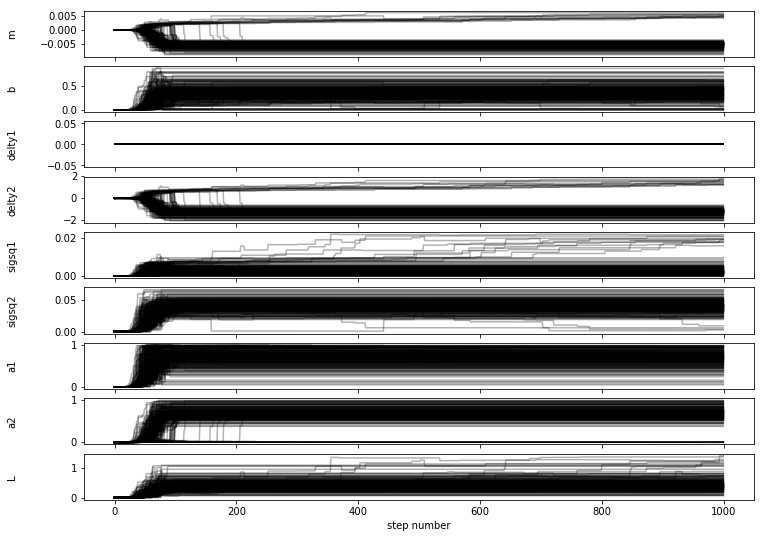

In [29]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "sigsq1", "sigsq2", "a1", "a2", "L"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    #(nwalkers, nsteps, dim)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_matrixeq22_L.png")
plt.show()

In [30]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

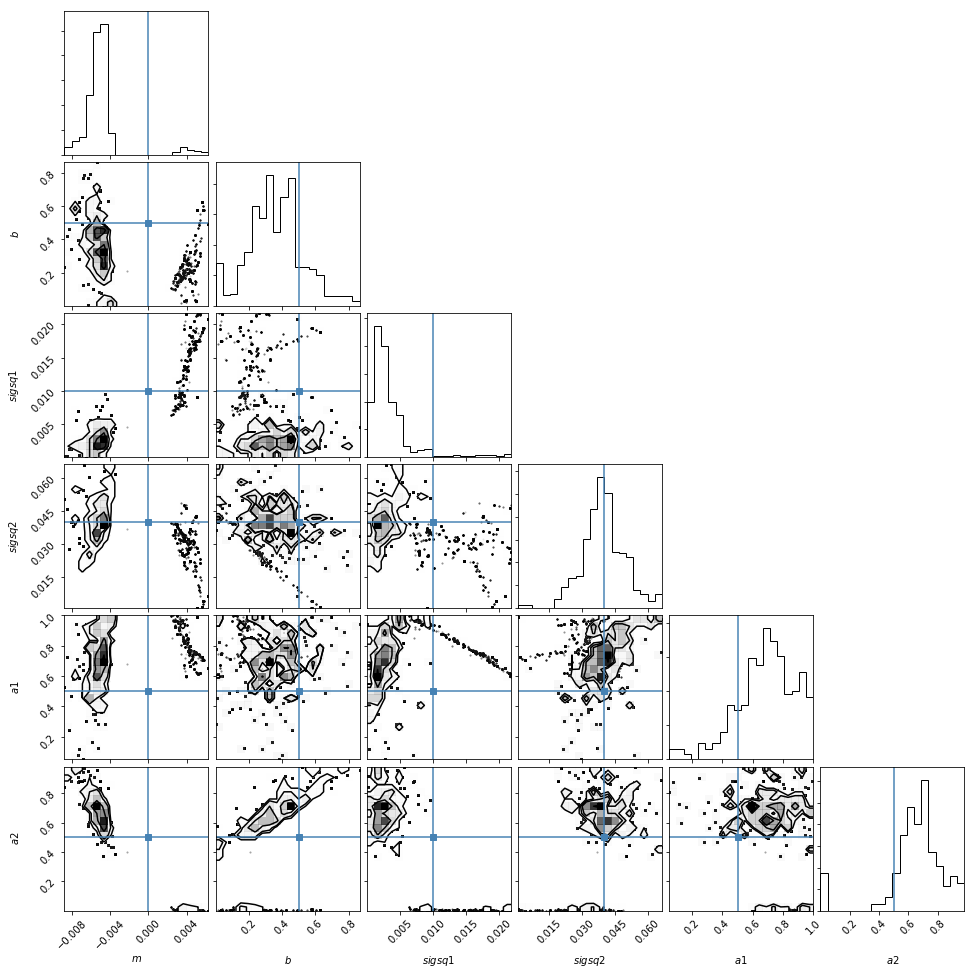

In [31]:
fig = corner.corner(flat_samples[:,[0,1,4,5,6,7]], labels=["$m$", "$b$", "$sigsq1$", "$sigsq2$", "$a1$", "$a2$"],
                      truths=[m_true, b_true, sigsq1_true, sigsq2_true, a1_true, a2_true])
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_corner_matrixeq22_L.png")

In [32]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>